In [1]:
from datetime import datetime

def xl_to_timestamp(dates, times):
    conv_datetime = []
    #split into MM/DD/YY
    for i in np.arange(dates.size):
        date = dates[i]
        time = times[i]
        date_split = date.split('/')
        year = int(date_split[2])
        month = int(date_split[0])
        day = int(date_split[1])
        time_split = time.split(':')
        hour = int(time_split[0])
        minute = int(time_split[1])
        second = int(time_split[2])

        #create datetime object and convert to timestamp
        conv_datetime.append(datetime(year, month, day, hour, minute, second).timestamp())
    return conv_datetime
    

# Enter test configuration here:

Text(0.5, 1.0, 'Internal Temperatures')

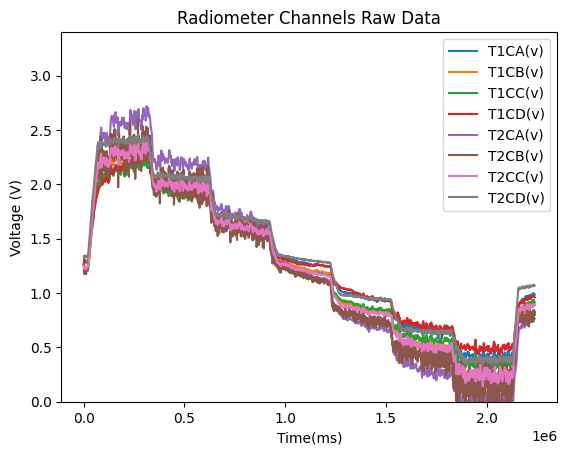

<Figure size 640x480 with 0 Axes>

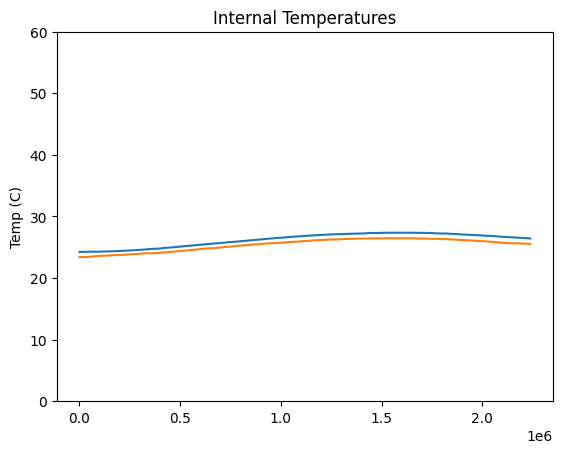

In [2]:
#imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.optimize import curve_fit


# -------------ADJUST FOR YOUR PROCEDURE------------------#

file_name = 'radiometer5_CH13-43_BB13-43_101323_sensor'
sensor_file = 'Data/' + file_name + '.csv'

#convert time column to military time
chamber_file_name = 'radiometer3_CH10-35_BB5-55_100423_chamber'
chamber_file = 'Data/Chamber/' + chamber_file_name + '.csv'

#set to true if you have chamber data
have_chamber_data = False

offset = 60000 * 0 #value should be 60000 * minutes for how long the sensor was on before sweep
high_temp = 43
low_temp = 13
temp_interval = -5
temp_ranges = np.arange(high_temp, low_temp - abs(temp_interval), temp_interval) #range and interval of temperature steps
time_interval = 5 #minute length that each temperature is held

time_interval_ms = 60000 * time_interval #convert minutes to milliseconds
begin_cutoff = 60000 * 2 #60000 * number of minutes to cut off from beginning of each temp
end_cutoff = 60000 * 1 #60000 * number of minutes to cut off from ending of each temp

#chamber_temps = [10, 15, 20, 25, 30, 35]
#chamber_temps = [43, 38, 33, 28, 23, 18, 13]
chamber_temps = [25]
chamb_time_interval = 60000 * 720


window_size = 60 #used for applying rolling window, number of seconds to use a rolling window for

# -------------ADJUST FOR YOUR PROCEDURE------------------#

# -------------UNCOMMENT FOR PLOTTING BB TEMP------------------#
#bb_file = 'Data/radiometer1_30_5-55_061623_BB.txt'

# bb_df = pd.read_csv(bb_file) #read blackbody temperatures from text file
#bb_df.to_csv(r'Data/radiometer1_30_5-55_061623_BB.csv', index = None)

#bb_df.columns = ['BB Temp']
#display(bb_df)
# -------------UNCOMMENT FOR PLOTTING BB TEMP------------------#

data = pd.read_csv(sensor_file)
if not os.path.exists('Reports/' + file_name):
     os.mkdir('Reports/' + file_name)
for temp in chamber_temps:
     if not os.path.exists('Reports/' + file_name + '/' + str(temp)):
          os.mkdir('Reports/' + file_name + '/' + str(temp))
     
channel_col = []
internal_col = []
nums = [1,2]
channels = ['A', 'B', 'C', 'D']
for num in nums:
     for chan in channels:
          channel_col.append("T" + str(num) + "C" + str(chan) + "(v)")
     internal_col.append("T" + str(num) +"Therm(c)")

if have_chamber_data:
     data_actual_cham = pd.read_csv(chamber_file)
     columns_to_keep = ['Date (MDY)', 'Time', 'TEMPERTURE (Deg C)']
     data_actual_cham = data_actual_cham[columns_to_keep]
     data_actual_cham.insert(loc = 0,
            column = "Time (ms)",
            value = xl_to_timestamp(data_actual_cham['Date (MDY)'], data_actual_cham['Time']))
     data_actual_cham['Time (ms)'] -= data_actual_cham['Time (ms)'].iloc[0]
     data_actual_cham['Time (ms)'] *= 1000
# -------------UNCOMMENT FOR ROLLING WINDOW------------------#

"""#window = scipy.signal.gaussian(M=30, std=6)
#smoothed = np.convolve(data[channel_col], window, mode='valid')
data_rolling = data[channel_col].rolling(window_size).mean()
#data_rolling = smoothed

data_rolling.insert(loc = 0,
     column = "Time(ms)",
     value = data["Time(ms)"])
data_rolling.drop(data_rolling.index[:window_size], inplace=True)
plt.figure()
data_rolling.plot(x = "Time(ms)", y = channel_col)
data = data_rolling """

# -------------UNCOMMENT FOR ROLLING WINDOW------------------#     

#channel_col.remove("T2CA(v)") #used to remove clipping channel
#channel_col.remove("T2CB(v)") #used to remove clipping channel
data = data[(data["Time(ms)"] < (offset + len(chamber_temps) * chamb_time_interval))]
data[(data["Time(ms)"] > (0))].plot(x = "Time(ms)", y = channel_col)
plt.title("Radiometer Channels Raw Data")
plt.ylim([0, 3.4])
plt.ylabel("Voltage (V)")

plt.figure()


if have_chamber_data:
     chamb_start = 0
     i = 1
     data_chamber_temps = []
     for cham in chamber_temps:
          plt.subplot(1,len(chamber_temps), i)
          data_cham = data[(data["Time(ms)"] > (chamb_start)) & (data["Time(ms)"] < (chamb_start + chamb_time_interval))]
          plt.plot(data_cham.loc[:,"Time(ms)"], data_cham.loc[:,channel_col])
          plt.legend(channel_col, fontsize = 10)
          plt.title("Radiometer Channels Raw Data (Chamber Temp: " + str(cham) + "\N{DEGREE CELSIUS})")
          plt.ylim([0, 3.4])
          plt.ylabel("Voltage (V)")
          i += 1
          chamb_start += chamb_time_interval
          data_chamber_temps.append(data_cham)
     
plt.subplots_adjust(left=0.1, right=10, bottom=0.1, top=1.9, wspace=0.3, hspace=1)
plt.savefig('Reports/' + file_name + '/raw_data_' + file_name + '.png', bbox_inches='tight')

#plot internals
plt.figure()
plt.ylim([0, 60])
plt.plot(data.loc[:,"Time(ms)"], data[internal_col])
plt.ylabel("Temp (C)")
plt.title("Internal Temperatures")


# Segment the data into different BB temps

In [4]:
#segment the data into the different BB temps
raw_cleaned_df = pd.DataFrame()
raw_averaged_cleaned_df = pd.DataFrame()
chamber_temp_dicts = []
lower_bound = offset #time after turning on radiometer

#for each chamber temperature, segment the data, clean by removing beginning and ending, and save a separate copy with a rolling average applied to it
for chamber_temp in chamber_temps:
    temp_dict = {}
    averaged_temp_dict = {}
    if len(chamber_temps) > 1:
        lower_bound += time_interval_ms #ignore the first interval (25C before the sweep)
    #create dictionary of dataframes, cutoff 5 minutes from begininng and half a minute from the end to obtain stabilized temp
    for i in range(0, temp_ranges.size): 
        temp_dict[str(temp_ranges[i])] = data[(data["Time(ms)"] > (lower_bound+begin_cutoff)) & (data["Time(ms)"] < (lower_bound + time_interval_ms-end_cutoff))]
        temp_dict[str(temp_ranges[i])].insert(loc = 1,
            column = "BB Temp",
            value = temp_ranges[i])

        
        #copy segmented temperature, perform rolling mean
        temp_dict_copy = temp_dict[str(temp_ranges[i])].copy()
        averaged_temp_dict[str(temp_ranges[i])] = temp_dict_copy[channel_col + internal_col].rolling(window_size).mean()

        #re-add BB temp and time labels
        averaged_temp_dict[str(temp_ranges[i])].insert(loc = 0,
            column = "BB Temp",
            value = temp_ranges[i])
        averaged_temp_dict[str(temp_ranges[i])].insert(loc = 0,
            column = "Time(ms)",
            value = data["Time(ms)"])
        
        #drop the first few samples not in window
        averaged_temp_dict[str(temp_ranges[i])].drop(averaged_temp_dict[str(temp_ranges[i])].index[:window_size], inplace=True)
        lower_bound += time_interval_ms

    #
    chamber_temp_dicts.append(temp_dict)
    raw_cleaned_df = pd.concat(list(temp_dict.values()))
    raw_cleaned_df.to_csv('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_raw_cleaned_' + file_name + '.csv')

    raw_averaged_cleaned_df = pd.concat(list(averaged_temp_dict.values()))
    raw_averaged_cleaned_df.to_csv('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_raw_averaged_cleaned_' + file_name + '.csv')
#remove chamber data after sweep ends
if have_chamber_data:
    data_actual_cham = data_actual_cham[(data_actual_cham["Time (ms)"] < (lower_bound + time_interval_ms -end_cutoff))]
    data_actual_cham.to_csv('Reports/' + file_name + '/' + 'chamber_cleaned_' + file_name + '.csv')
display(raw_cleaned_df)



,Time(ms),BB Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T1Therm(c),T2CA(v),T2CB(v),T2CC(v),T2CD(v),T2Therm(c)
106,120507,43,2.067443,2.126308,2.040944,2.038338,24.277095,2.411532,2.101375,2.184842,2.355545,23.597099
107,121636,43,2.050850,2.105468,2.021597,2.023780,24.276388,2.385072,2.067252,2.162236,2.356779,23.596529
108,122765,43,2.041050,2.094519,2.011847,2.015643,24.276299,2.371289,2.091232,2.157356,2.359595,23.596615
109,123894,43,2.040587,2.101485,2.019784,2.021646,24.275740,2.405113,2.191782,2.196149,2.370304,23.597470
110,125023,43,2.055240,2.118579,2.035817,2.034147,24.277183,2.389288,2.062132,2.171942,2.351374,23.598125
...,...,...,...,...,...,...,...,...,...,...,...,...
1801,2035110,13,0.464272,0.291945,0.404081,0.540177,26.819359,0.000280,0.137891,0.233396,0.381960,25.894426
1802,2036277,13,0.476846,0.305691,0.417558,0.553358,26.846784,0.000253,0.081014,0.222635,0.379632,25.863328
1803,2037406,13,0.466214,0.291370,0.403054,0.538377,26.844517,0.007474,0.286660,0.253900,0.405866,25.861101
1804,2038535,13,0.444130,0.264088,0.375588,0.518713,26.841250,0.040878,0.359530,0.295895,0.416332,25.860783


# Plot the sensor readings at different blackbody temperatures

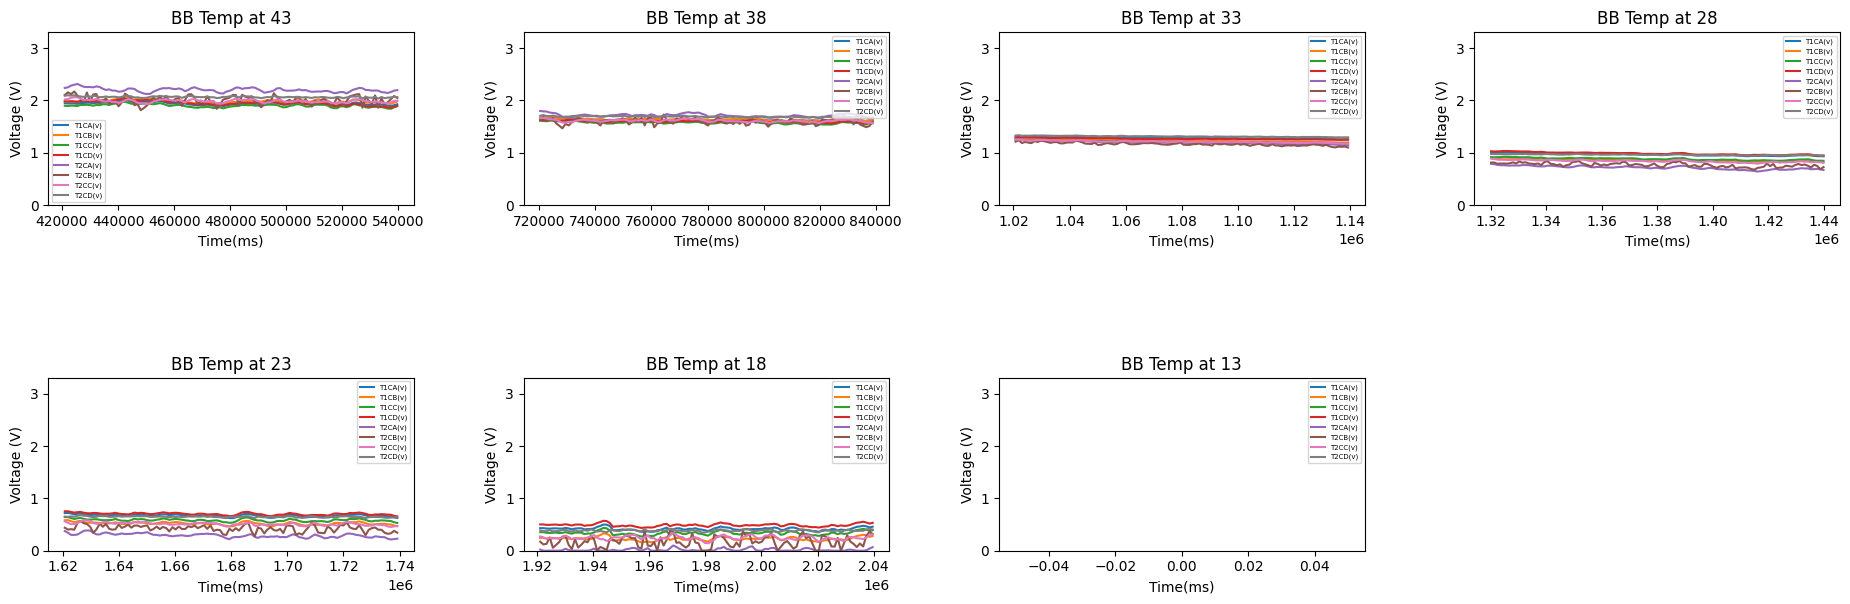

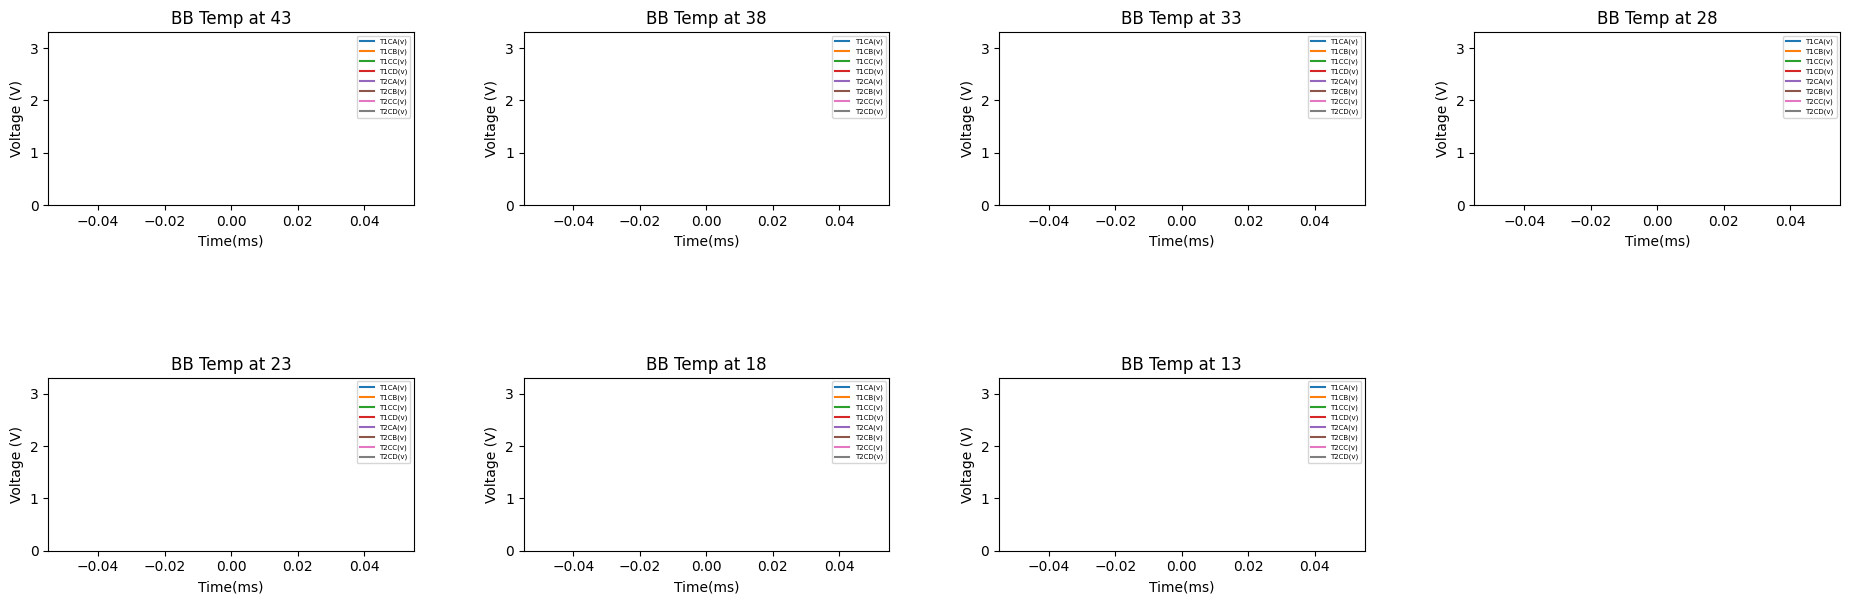

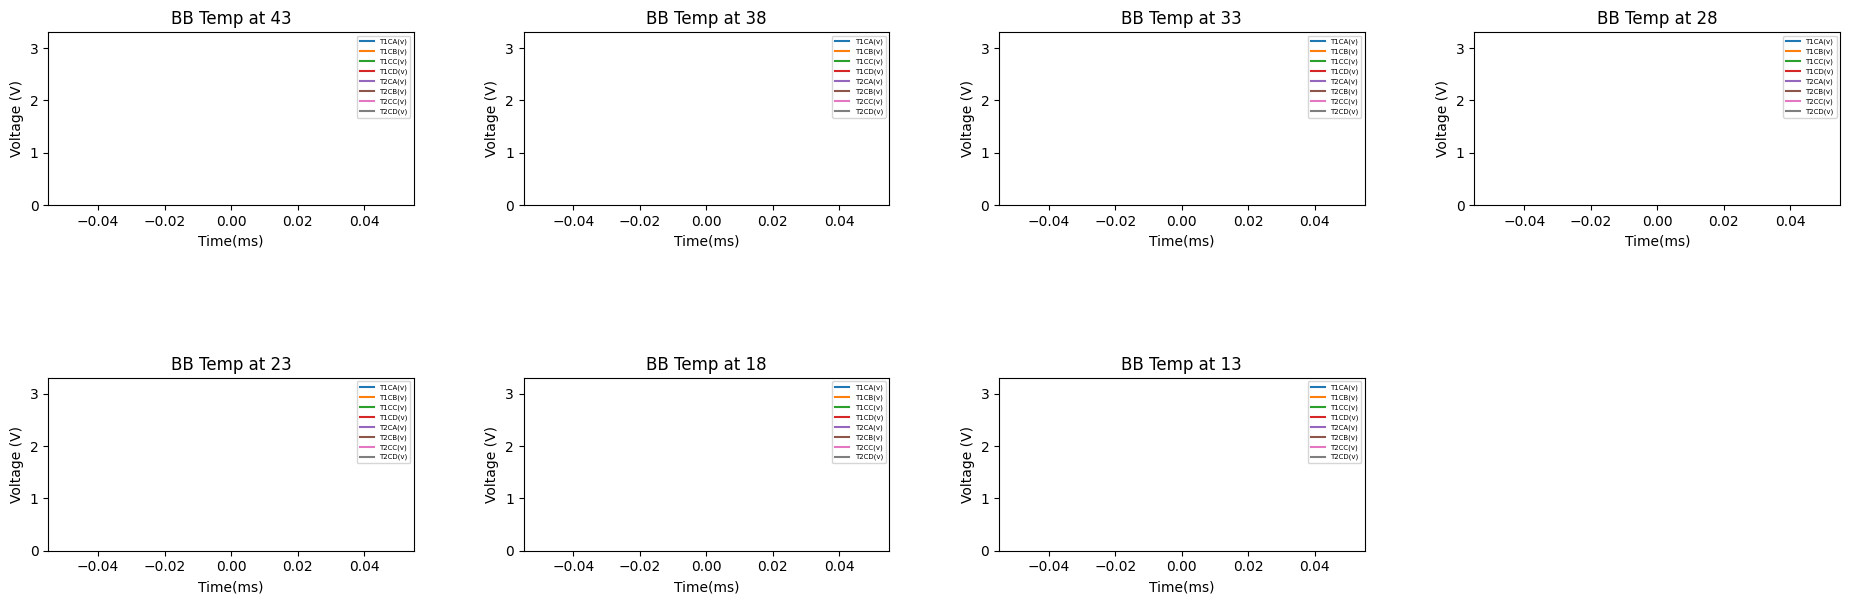

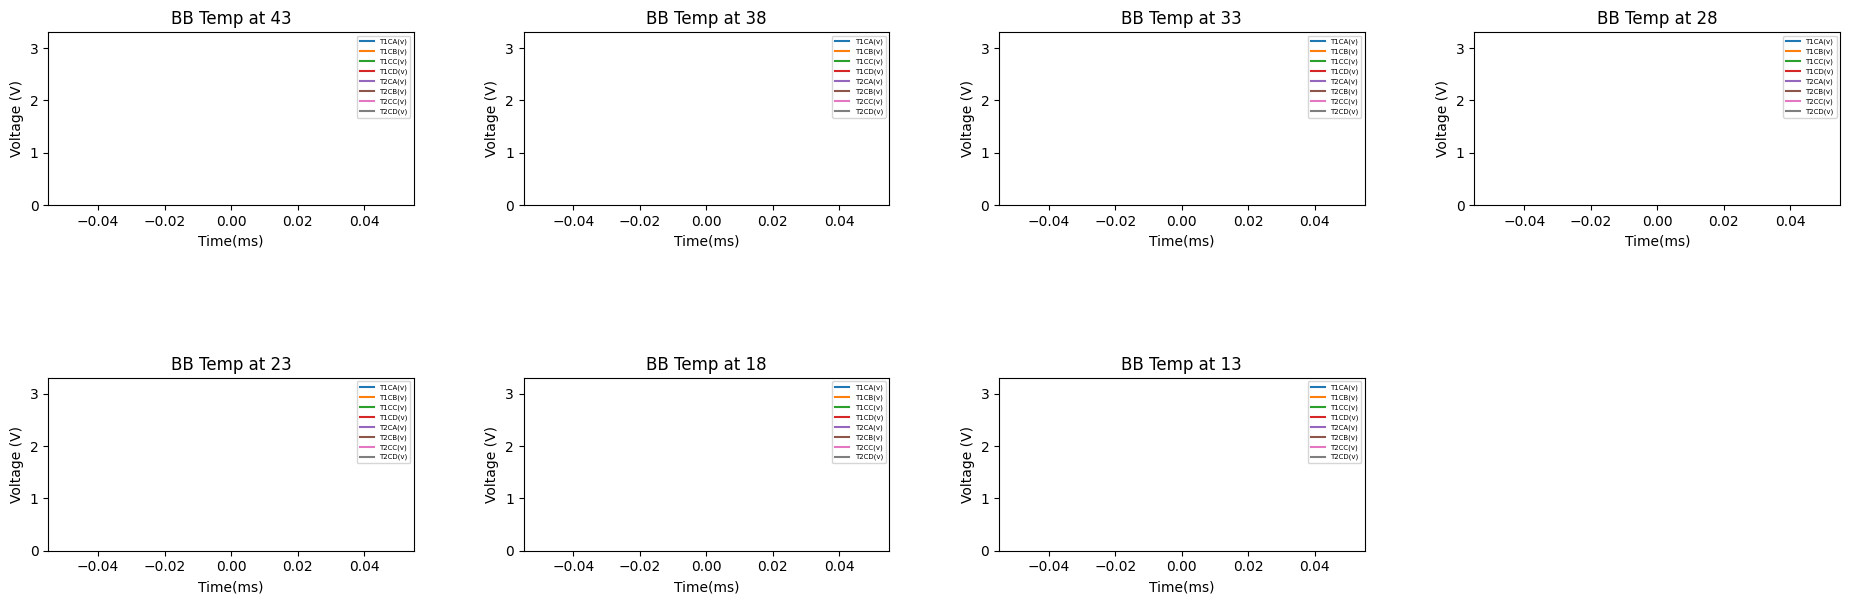

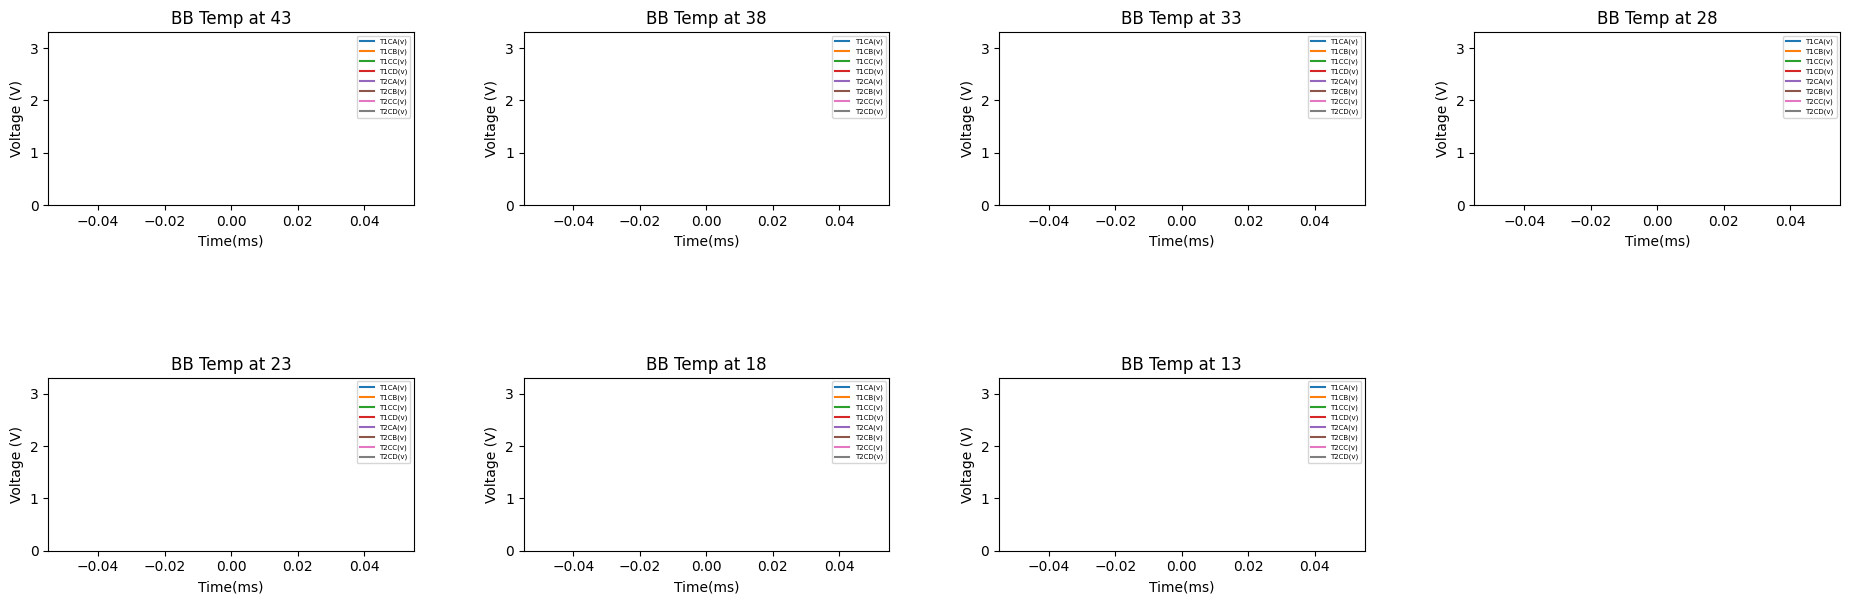

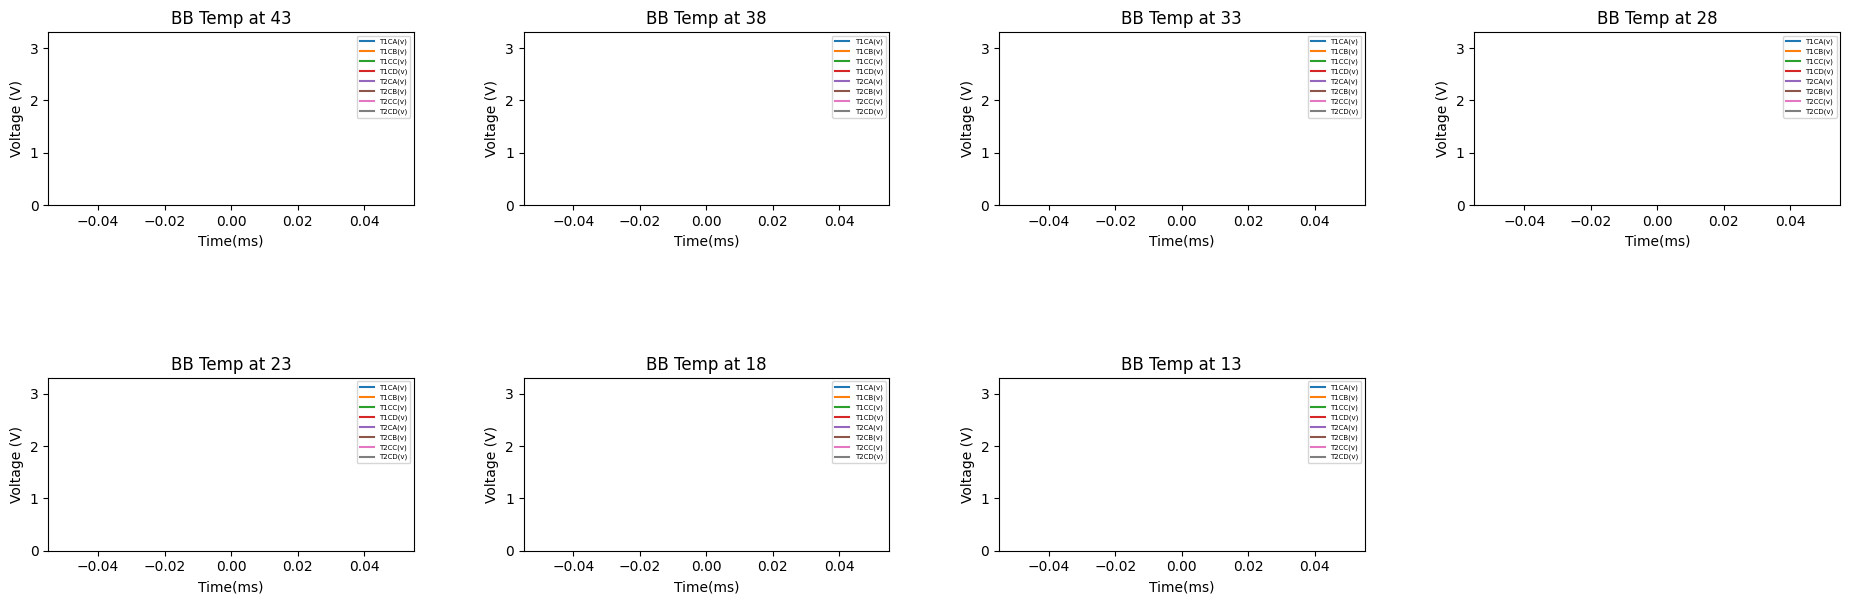

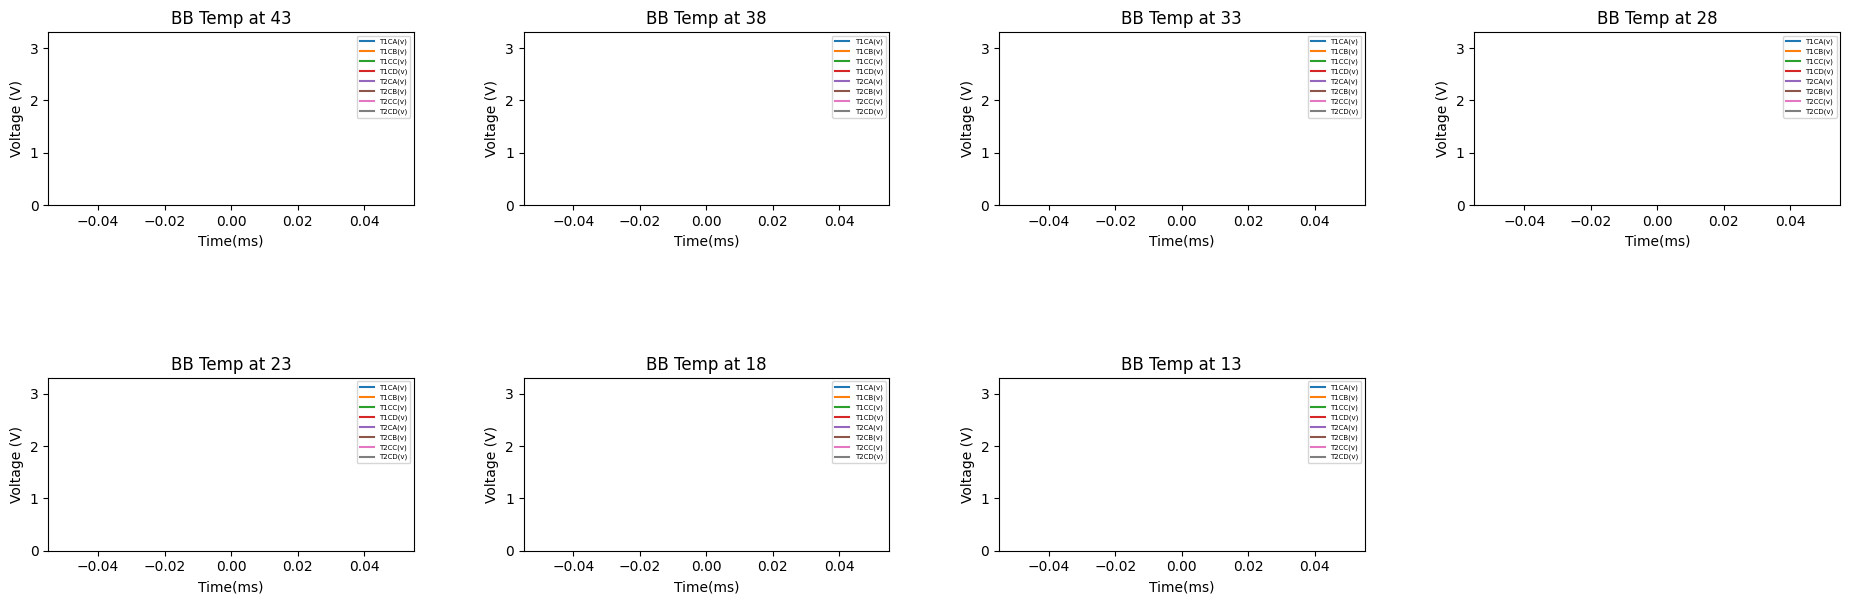

In [ ]:
temp_max_min = pd.DataFrame()

for temp_dict in chamber_temp_dicts:
    plt.figure()
    i = 1
    chamber_temp = chamber_temps[i - 1]
    for key in temp_dict:
        plt.subplot(3, 4, i)
        plt.subplots_adjust(left=0.1, right=2.9, bottom=0.1, top=1.9, wspace=0.3, hspace=1)
        plt.plot(temp_dict[key].loc[:,"Time(ms)"], temp_dict[key].loc[:,channel_col])
        plt.title("BB Temp at " + key)
        plt.ylabel("Voltage (V)")
        plt.ylim([0, 3.3])
        plt.xlabel("Time(ms)")
        plt.legend(channel_col, fontsize = 5)
        i += 1
        max_temp = temp_dict[key].max() #get max temps
        max_temp_df = pd.DataFrame({'Chamber: ' + str(chamber_temp) + ' Max at ' + str(key): max_temp}).T

        min_temp = temp_dict[key].min() #get min temps 
        min_temp_df = pd.DataFrame({'Chamber: ' + str(chamber_temp) + ' Min at ' + str(key): min_temp}).T

        vpp = max_temp - min_temp #calculate peak-to-peak
        vpp_df = pd.DataFrame({'Chamber: ' + str(chamber_temp) + ' VPP' + str(key): vpp}).T
        temp_max_min= pd.concat([temp_max_min, max_temp_df, vpp_df]) #transpose
        plt.savefig('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_segmented_temp_voltages_' + file_name + '.png', bbox_inches='tight')


plt.show()
#display(temp_max_min) #plot segmented temp data

# Create Histograms For Each Channel

In [ ]:
#create histograms for each channel
""" for key in temp_dict:
    plt.figure()
    temp = temp_dict[key]
    i = 1
    for chan in channel_col:
        plt.subplot(2, 4, i)
        plt.hist(temp[chan], bins=30, density=True, alpha=0.6, color='g')
        plt.title(chan)
        i += 1 """

" for key in temp_dict:\n    plt.figure()\n    temp = temp_dict[key]\n    i = 1\n    for chan in channel_col:\n        plt.subplot(2, 4, i)\n        plt.hist(temp[chan], bins=30, density=True, alpha=0.6, color='g')\n        plt.title(chan)\n        i += 1 "

# Calculate average, std. dev., and sensitivity for voltage

In [ ]:
#calculate averages, std devs and rms values
chamber_ch_avgs = []
cham_temp_index = 0
for temp_dict in chamber_temp_dicts:
    ch_avgs = pd.DataFrame()
    ch_std_dev = pd.DataFrame()
    ch_sensitivity = pd.DataFrame()
    ch_rms = pd.DataFrame()
    for key in temp_dict:
        #calulcate average, std. dev, rms voltage for each channel
        temps = temp_dict[key]
        ch_avgs[key] = temps[channel_col].mean()
        ch_std_dev[key] = temps[channel_col].std()
        ch_rms[key]  = np.sqrt((temps[channel_col] ** 2).mean())
    ch_avgs=ch_avgs.T
    ch_avgs.insert(loc = 0,
            column = 'BB Temp',
            value = temp_ranges)
    ch_std_dev =ch_std_dev.T
    ch_std_dev.insert(loc = 0,
            column = 'BB Temp',
            value = temp_ranges)

    ch_rms =ch_rms.T
    ch_rms.insert(loc = 0,
            column = 'BB Temp',
            value = temp_ranges)

    i = 0
    for temp in temp_ranges:
        #calculate sensitivity by dividing the difference in voltage by the difference in temperature
        if not (i == 0):
            ch_sensitivity[str(temp_ranges[i-1]) + "to" + str(temp_ranges[i])] = (ch_avgs.iloc[i] - ch_avgs.iloc[i-1])/ temp_interval
        i += 1
    ch_sensitivity.drop(index=ch_sensitivity.index[0], axis=0, inplace=True)
    ch_sensitivity = ch_sensitivity.T
    avg_sensitivity = ch_sensitivity.mean().mean()
    print("Average sensitivity: " + str(avg_sensitivity))
    avg_std_dev = ch_std_dev[channel_col].mean().mean()
    print("Average Std. Dev: " + str(avg_std_dev))
    snr = avg_sensitivity / avg_std_dev
    print("SNR: " + str(snr))

    #use to show statistics in notebook
    #display(ch_avgs) #display statistics
    #display(ch_std_dev)
    #display(ch_sensitivity)
    #display(ch_rms)

    #convert to csv files
    #ch_avgs.to_csv('Reports/' + file_name + '/' + str(chamber_temps[cham_temp_index]) + '/' + str(chamber_temps[cham_temp_index]) + '_voltage_avg_' + file_name + '.csv')
    #ch_std_dev.to_csv('Reports/' + file_name + '/' + str(chamber_temps[cham_temp_index]) + '/' + str(chamber_temps[cham_temp_index]) + '_voltage_std_dev_' + file_name + '.csv')
    #ch_sensitivity.to_csv('Reports/' + file_name + '/' + str(chamber_temps[cham_temp_index]) + '/' + str(chamber_temps[cham_temp_index]) + '_voltage_sens_' + file_name + '.csv')

    cham_temp_index += 1
    chamber_ch_avgs.append(ch_avgs)

# -------------UNCOMMENT FOR PLOT OF AVERAGE VOLTAGE VS. BB TEMP------------------#
""" plt.plot(ch_avgs.loc[:,"Temp"], ch_avgs.loc[:,channel_col], marker = '.')
plt.legend(channel_col, fontsize = 5)
plt.xlabel("Temp (\N{DEGREE CELSIUS})")
plt.ylabel("Average Voltage (V)")
plt.title("Avg. Voltage vs. Blackbody Temperature")
plt.savefig('Reports/' + file_name + '/' + 'avg_voltage_' + file_name + '.png', bbox_inches='tight')  """
# -------------UNCOMMENT FOR PLOT OF AVERAGE VOLTAGE VS. BB TEMP------------------#

Average sensitivity: 0.06873610033773583
Average Std. Dev: 0.02813694855989765
SNR: 2.442912392984304
Average sensitivity: nan
Average Std. Dev: nan
SNR: nan
Average sensitivity: nan
Average Std. Dev: nan
SNR: nan
Average sensitivity: nan
Average Std. Dev: nan
SNR: nan
Average sensitivity: nan
Average Std. Dev: nan
SNR: nan
Average sensitivity: nan
Average Std. Dev: nan
SNR: nan
Average sensitivity: nan
Average Std. Dev: nan
SNR: nan


' plt.plot(ch_avgs.loc[:,"Temp"], ch_avgs.loc[:,channel_col], marker = \'.\')\nplt.legend(channel_col, fontsize = 5)\nplt.xlabel("Temp (℃)")\nplt.ylabel("Average Voltage (V)")\nplt.title("Avg. Voltage vs. Blackbody Temperature")\nplt.savefig(\'Reports/\' + file_name + \'/\' + \'avg_voltage_\' + file_name + \'.png\', bbox_inches=\'tight\')  '

# Equations for temperature and radiance calculations

In [ ]:
#Planck Radiance
def planck_radiance(wavelength, temperature):
    h = 6.62607015e-34  # Planck's constant
    c = 299792458  # Speed of light
    k = 1.38064852e-23  # Boltzmann constant

    #convert celsius to Kelvin
    temperature += 273.15
    
    numerator = 2 * h * c ** 2
    denominator = wavelength ** 5 * (np.exp((h * c) / (wavelength * k * temperature)) - 1)
    radiance = numerator / denominator
    return radiance

def linear_fit(x, slope , b):
    return slope * x + b

def quadratic_fit(x, a, b, c):
    return a * (x ** 2) + b * x + c

def gaussian_fit(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Convert voltages to temperatures for each channel

c:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


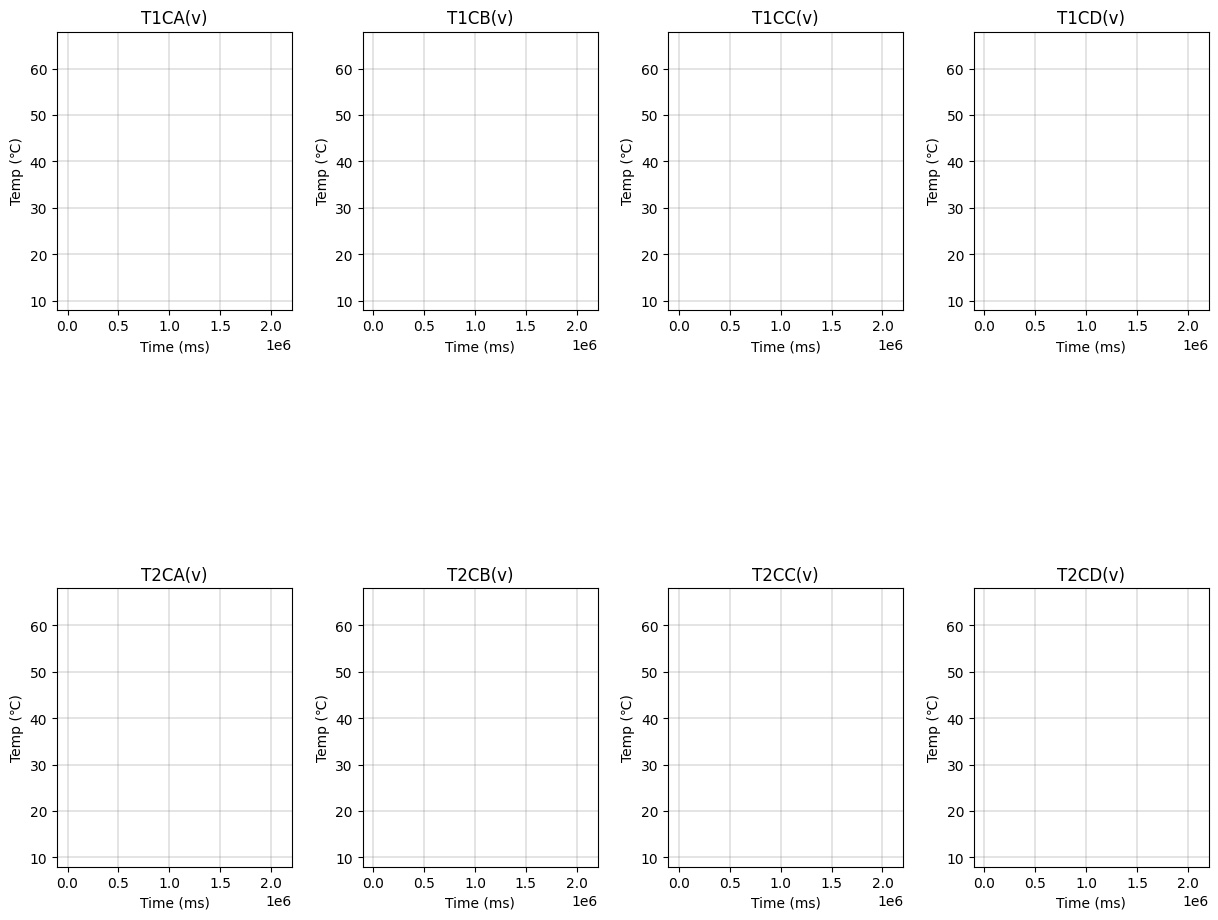

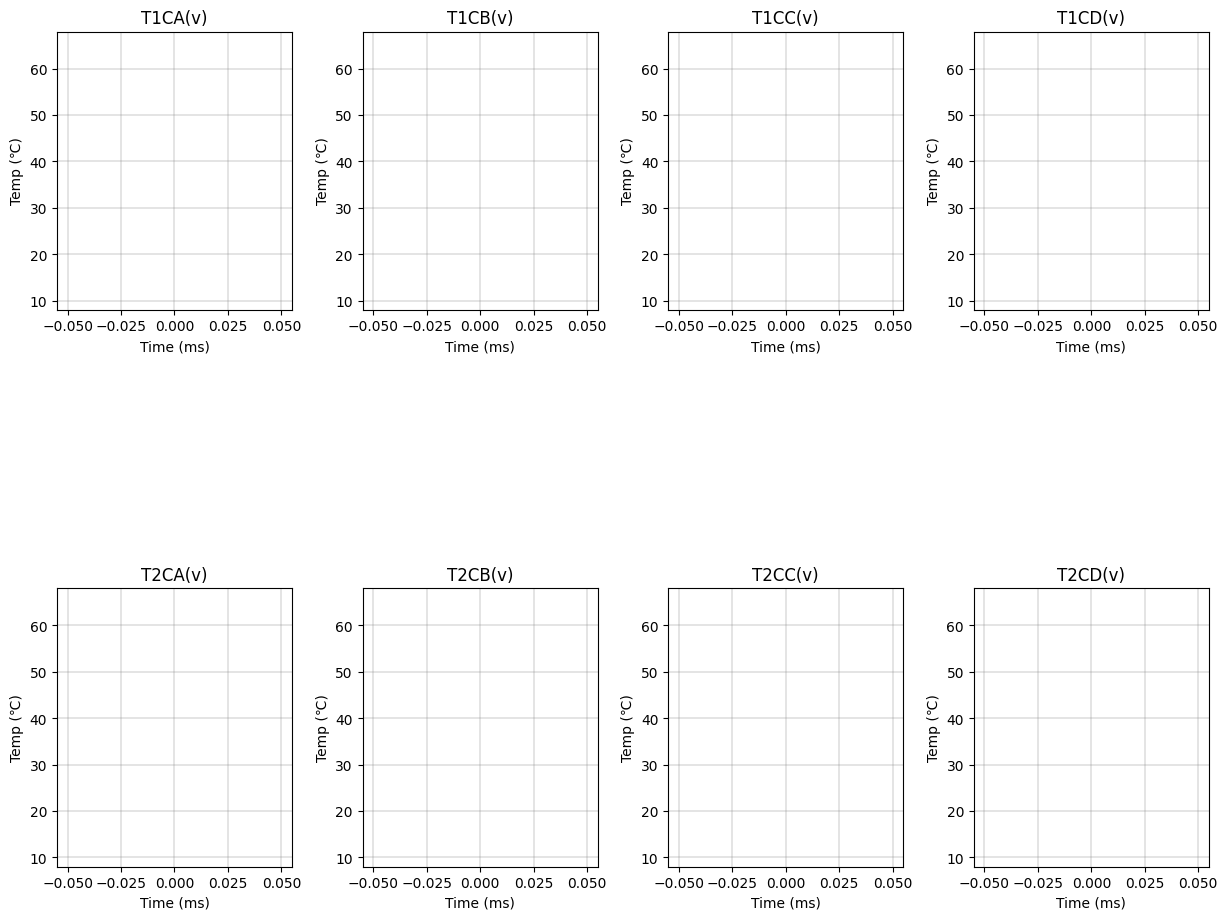

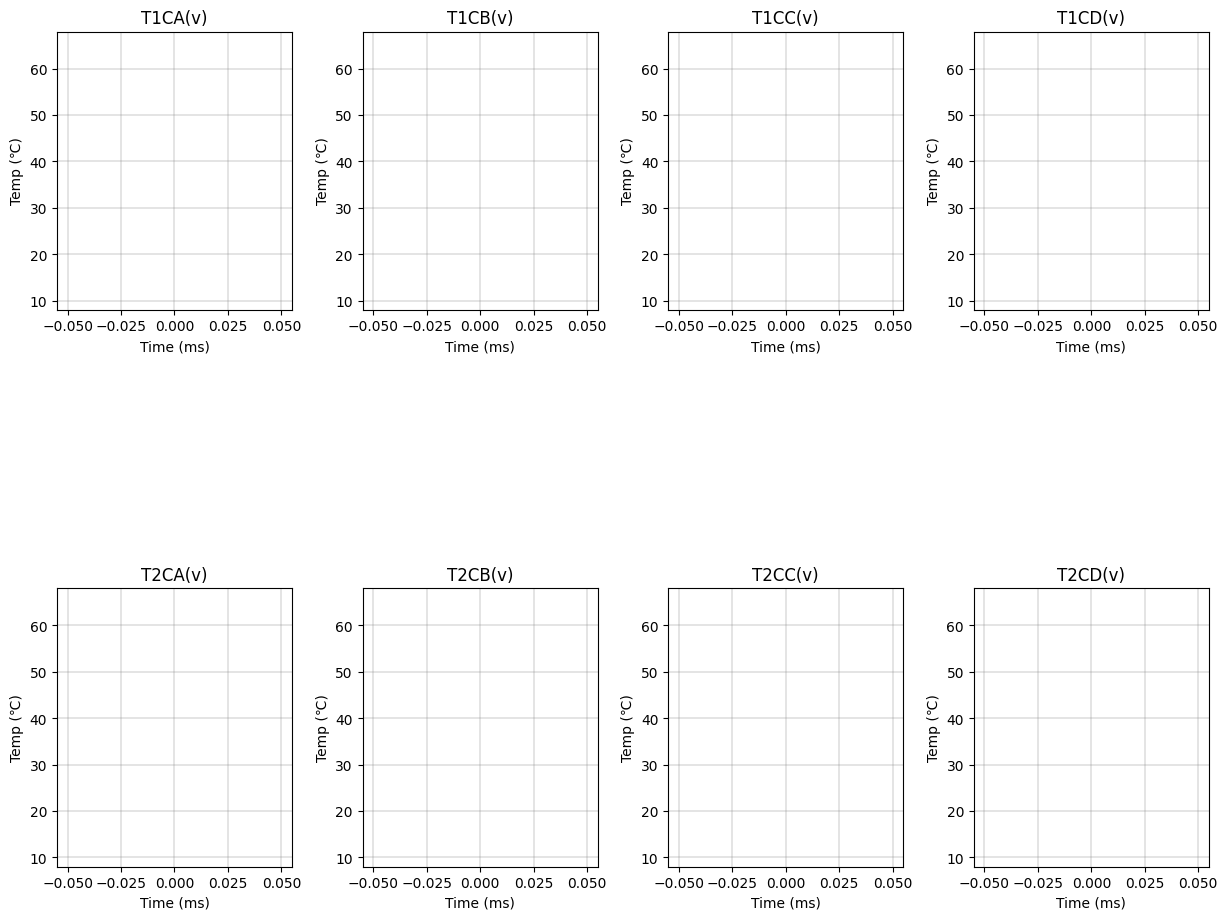

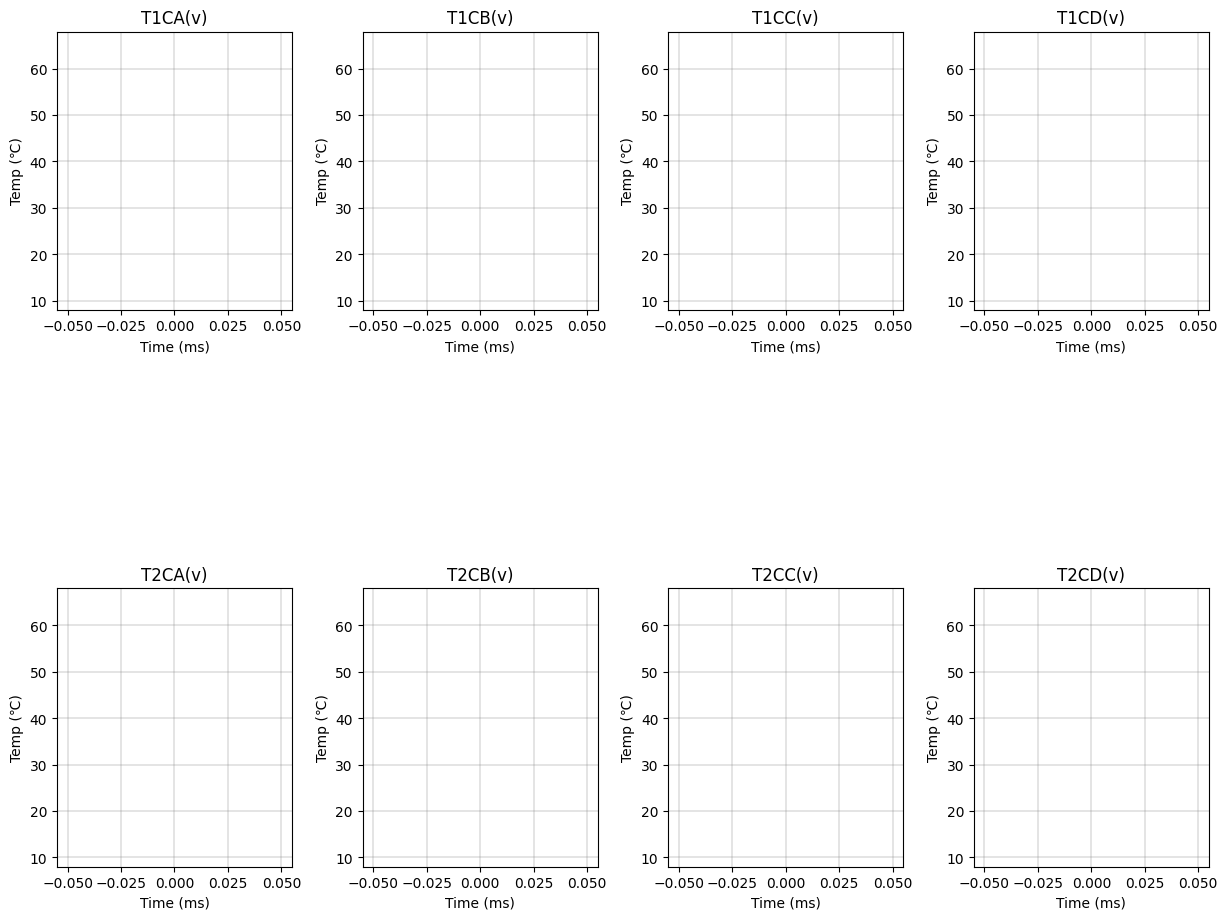

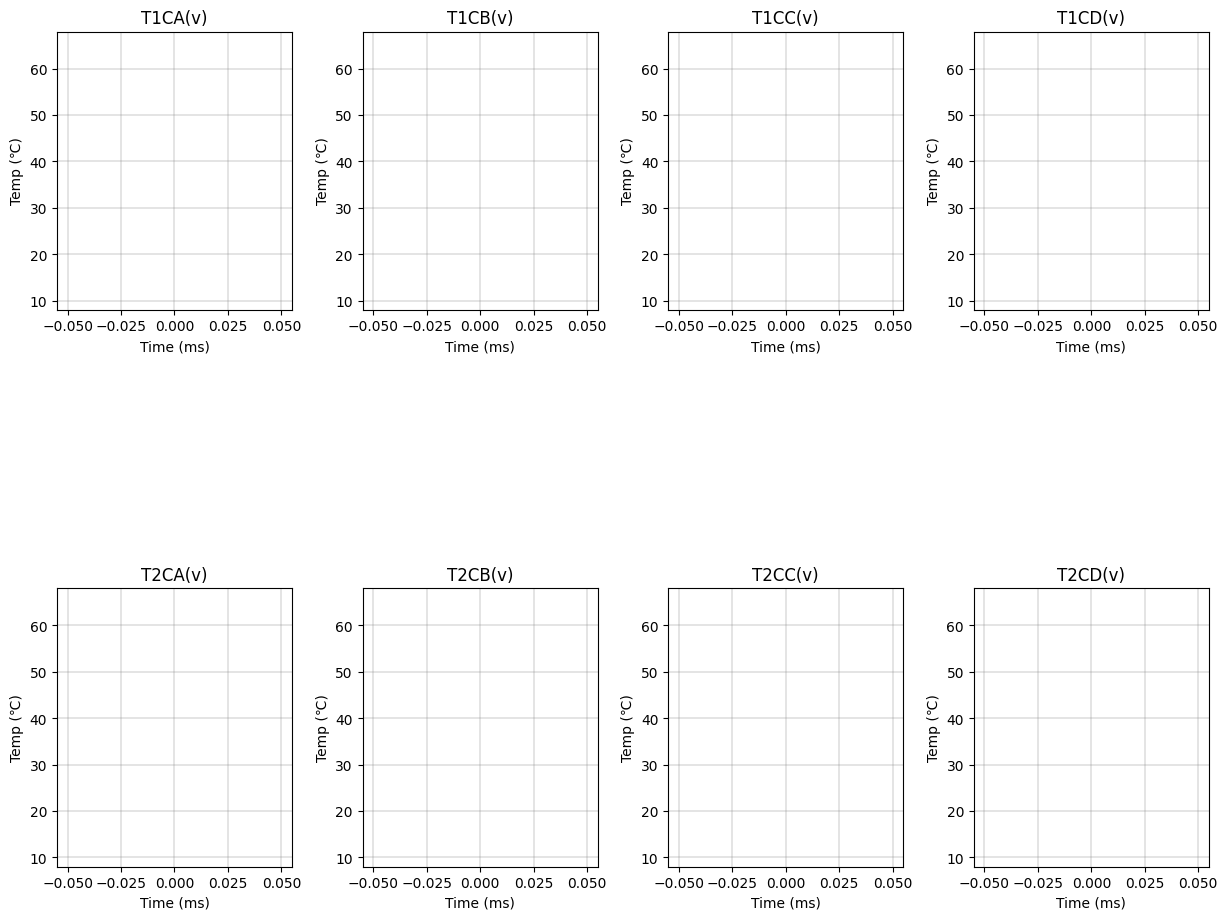

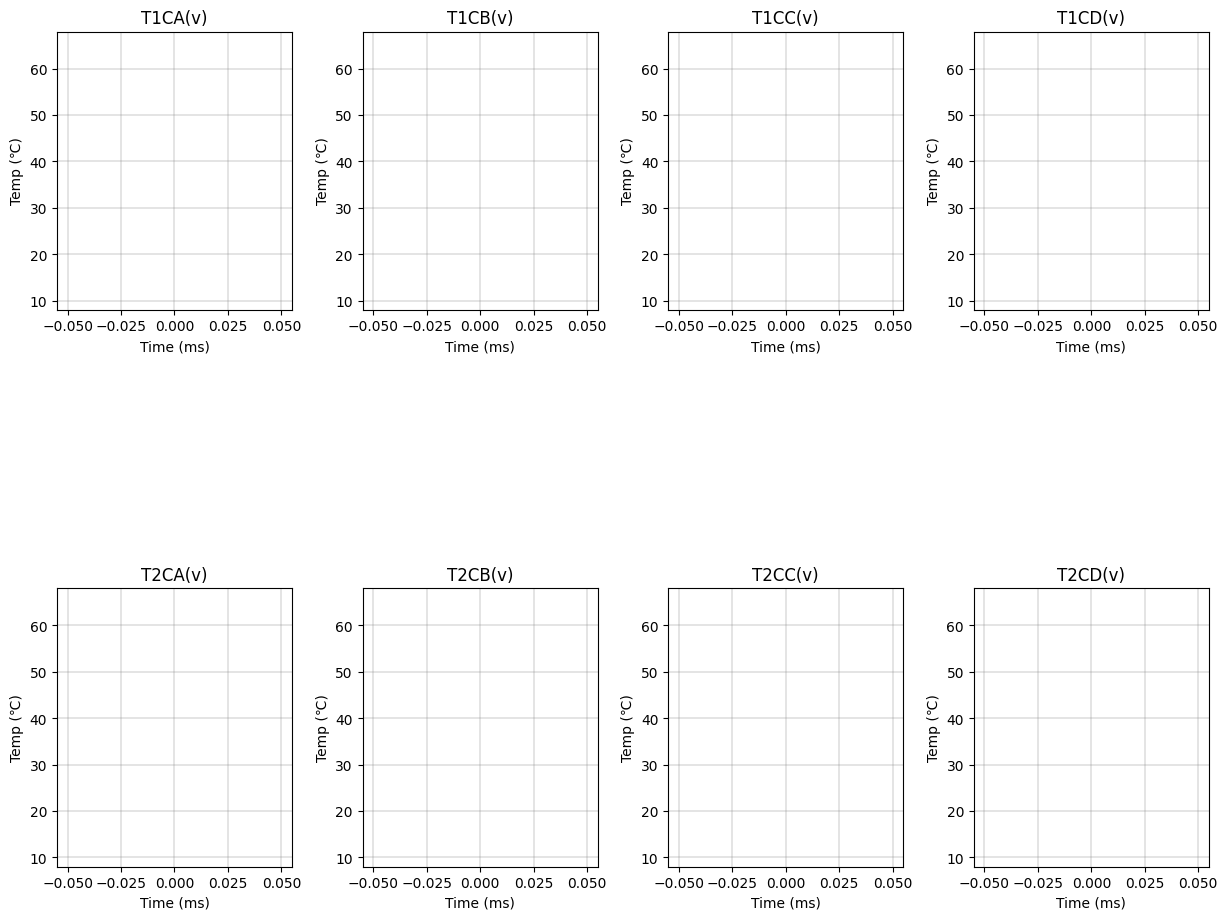

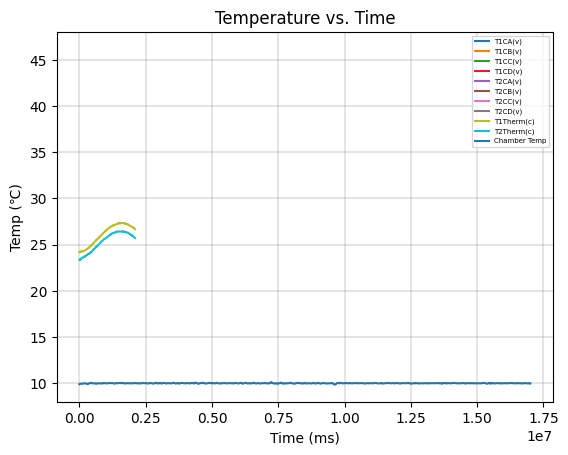

' #Plot error\nplt.figure()\nlower_bound = offset\n#display(data_temp)\nfor i in range(0, bb_df[\'BB Temp\'].size):\n    bb_temp = bb_df[\'BB Temp\']\n    data_temp_interval = data_temp[(data_temp["Time(ms)"] > (lower_bound)) & (data_temp["Time(ms)"] < (lower_bound + time_interval_ms))]\n    #display(data_temp_interval)\n    temp_error = pd.concat([temp_error, ((abs((data_temp_interval[channel_col] - bb_temp[i])/bb_temp[i])) * 100)]) #convert the voltage to a temp and calculate percent error\n    lower_bound += time_interval_ms\ntemp_times = data_temp[(data_temp["Time(ms)"] > (1200000)) & (data_temp["Time(ms)"] < (lower_bound))]["Time(ms)"]\ntemp_error.insert(loc = 0,column = \'Time(ms)\', value = temp_times)\n\nfor ch in channel_col:\n    plt.plot(temp_error["Time(ms)"], temp_error[ch])\n\nplt.xlabel("Time (ms)")\nplt.ylabel("Percent Error (%)")\nplt.title("Temperature Percent Error vs. Time")\nplt.grid(color=\'gray\', linestyle=\'-\', linewidth=0.3)\nplt.legend(channel_col, fontsize 

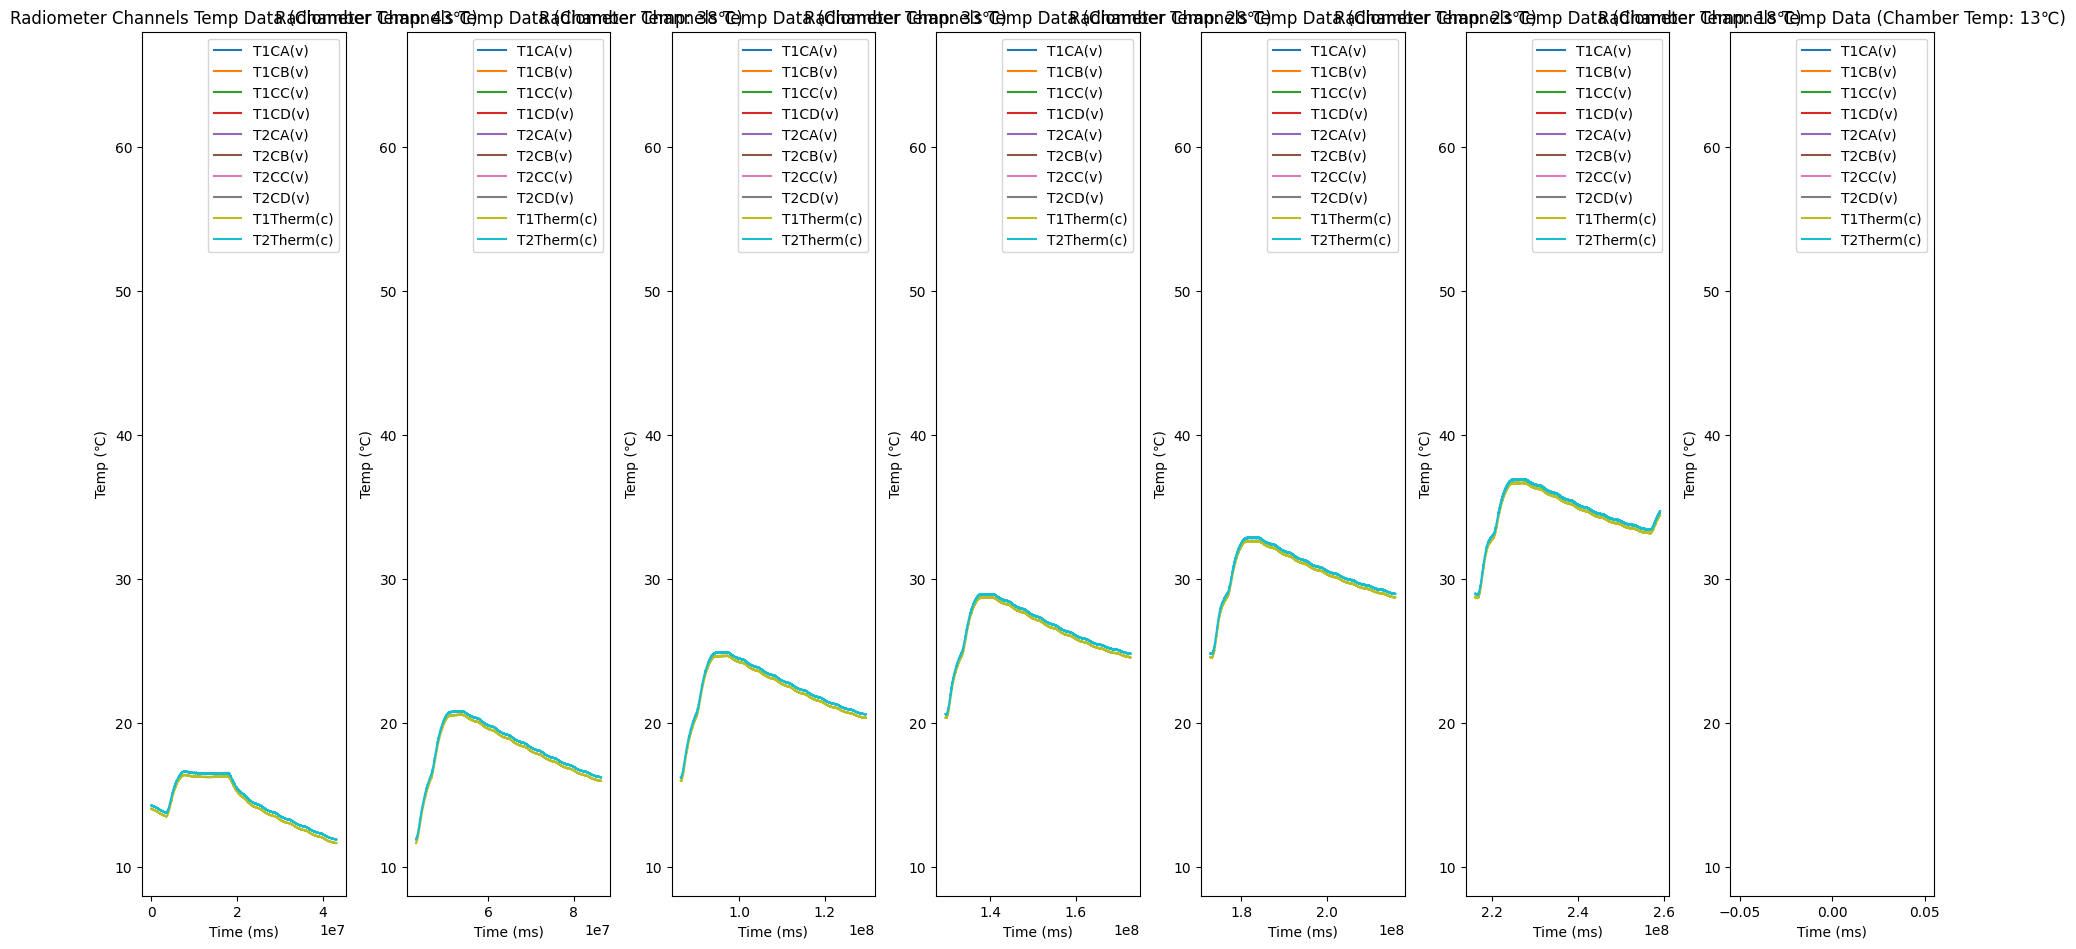

In [ ]:
#lists of linear fit coefficients
temp_popt = {}
temp_pcov = {}

combined_data_temp = pd.DataFrame()
bb_index = np.arange(1.2e6,8.4e6,0.6e6)

sensor_1_chans = channel_col[0:3]
sensor_2_chans = channel_col[4:7]

cham_temp_index  = 0
for data_to_convert in data_chamber_temps:
    data_temp = data_to_convert.copy()
    #temp_error = pd.DataFrame()
    plt.figure()
    i = 1
    ch_avg = chamber_ch_avgs[cham_temp_index]
    for chan in channel_col:
        #apply linear fit for each channel
        temp_popt[chan], temp_pcov[chan] = curve_fit(linear_fit, ch_avg[chan], ch_avg["BB Temp"])
        calc_temp = linear_fit(data[chan], *temp_popt[chan])
        data_temp[chan] = calc_temp
        ax = plt.subplot(3, 4, i)
        plt.subplots_adjust(left=0.1, right=1.9, bottom=0.1, top=3, wspace=0.3, hspace=1)
        
         #attempt to flatten by adding/subtracting difference between starting and current internal of each time frame
        if (chan in sensor_1_chans):
            internal = 'T1Therm(c)'
        else:
            internal = 'T2Therm(c)' 

        diff_factor = 1

        internal_temp = data_temp[internal]
        internal_temp_diff = internal_temp - internal_temp.iloc[30*60]
        data_temp[chan] = data_temp[chan] + (diff_factor * internal_temp_diff)


        plt.plot(data_temp.loc[:,"Time(ms)"], data_temp[chan])
        plt.xlabel("Time (ms)")
        plt.ylabel("Temp (\N{DEGREE CELSIUS})")
        plt.title(chan)
        plt.grid(color='gray', linestyle='-', linewidth=0.3)
        plt.ylim((temp_ranges.min() - 5,temp_ranges.max() + 25))
        i += 1
    plt.savefig('Reports/' + file_name + '/' + str(chamber_temps[cham_temp_index]) + '/' + str(chamber_temps[cham_temp_index]) + '_indiv_channel_temps_' + file_name + '.png', bbox_inches='tight')    
    cham_temp_index += 1
    combined_data_temp = pd.concat([combined_data_temp, data_temp])

combined_data_temp.to_csv('Reports/' + file_name + '/' + 'converted_temps_' + file_name + '.csv')
plt.show()

#plot temp data for entire capture
plt.figure()
for chan in channel_col:
    plt.plot(combined_data_temp["Time(ms)"], combined_data_temp[chan])
    plt.xlabel("Time (ms)")
    plt.ylabel("Temp (\N{DEGREE CELSIUS})")
    plt.title("Temperature vs. Time")
    plt.grid(color='gray', linestyle='-', linewidth=0.3)
    
    plt.ylim((temp_ranges.min() - 5,temp_ranges.max() + 5))
    #plt.scatter(bb_index, bb_df['BB Temp'])

#plot internal and chamber temps
plt.plot(data["Time(ms)"], data[internal_col])
plt.plot(data_actual_cham["Time (ms)"], data_actual_cham['TEMPERTURE (Deg C)'])
plt.legend(channel_col + internal_col + ["Chamber Temp"], fontsize = 5)
plt.savefig('Reports/' + file_name + '/' + 'temps_' + file_name + '.png', bbox_inches='tight')
plt.show()


plt.figure()
i = 1
chamb_time_interval = 60000 * 720
chamb_start = 0

conv_data_chamber_temps = [] #list of dataframes for each chamber temp, in units of C
for cham in chamber_temps:
     plt.subplot(1,len(chamber_temps), i)
     data_temp_cham = combined_data_temp[(combined_data_temp["Time(ms)"] > (chamb_start)) & (combined_data_temp["Time(ms)"] < (chamb_start + chamb_time_interval))]

    #plots channel data converted to temperature and internal temperature data
     plt.plot(data_temp_cham.loc[:,"Time(ms)"], data_temp_cham.loc[:,channel_col])
     plt.plot(data_temp_cham.loc[:,"Time(ms)"], data_temp_cham.loc[:,internal_col])
     plt.legend(channel_col + internal_col, fontsize = 10)
     plt.title("Radiometer Channels Temp Data (Chamber Temp: " + str(cham) + "\N{DEGREE CELSIUS})")
     plt.xlabel("Time (ms)")
     plt.ylabel("Temp (\N{DEGREE CELSIUS})")
     plt.ylim((temp_ranges.min() - 5,temp_ranges.max() + 25))
     i += 1
     chamb_start += chamb_time_interval
     conv_data_chamber_temps.append(data_cham)
     
plt.subplots_adjust(left=0.1, right=2.9, bottom=0.1, top=1.9, wspace=0.3, hspace=1)
plt.savefig('Reports/' + file_name + '/temps_indiv_chamber' + file_name + '.png', bbox_inches='tight')
# -------------UNCOMMENT FOR ERROR CALC, REQUIRES BB TEMPS------------------#
""" #Plot error
plt.figure()
lower_bound = offset
#display(data_temp)
for i in range(0, bb_df['BB Temp'].size):
    bb_temp = bb_df['BB Temp']
    data_temp_interval = data_temp[(data_temp["Time(ms)"] > (lower_bound)) & (data_temp["Time(ms)"] < (lower_bound + time_interval_ms))]
    #display(data_temp_interval)
    temp_error = pd.concat([temp_error, ((abs((data_temp_interval[channel_col] - bb_temp[i])/bb_temp[i])) * 100)]) #convert the voltage to a temp and calculate percent error
    lower_bound += time_interval_ms
temp_times = data_temp[(data_temp["Time(ms)"] > (1200000)) & (data_temp["Time(ms)"] < (lower_bound))]["Time(ms)"]
temp_error.insert(loc = 0,column = 'Time(ms)', value = temp_times)

for ch in channel_col:
    plt.plot(temp_error["Time(ms)"], temp_error[ch])

plt.xlabel("Time (ms)")
plt.ylabel("Percent Error (%)")
plt.title("Temperature Percent Error vs. Time")
plt.grid(color='gray', linestyle='-', linewidth=0.3)
plt.legend(channel_col, fontsize = 5)
plt.scatter(bb_index, bb_df['BB Temp'])
display(temp_error)
plt.plot(data["Time(ms)"], linear_fit(data["T2CD(v)"], *temp_popt["T2CD(v)"]))
plt.plot(data["T1CB(v)"], linear_fit(data["T1CB(v)"], *temp_popt["T1CB(v)"])) """
# -------------UNCOMMENT FOR ERROR CALC, REQUIRES BB TEMPS------------------#


# Calculate summary statistics in temperature domain


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
43,43,0.026743,0.029753,0.029934,0.042639,0.041453,0.080628,0.030257,0.015650
38,38,0.024956,0.027395,0.027175,0.017475,0.031192,0.054382,0.022698,0.013105
33,33,0.017231,0.020266,0.018912,0.022644,0.036377,0.037316,0.027735,0.020849
28,28,0.026749,0.029610,0.028157,0.032776,0.040625,0.043986,0.028944,0.018469
23,23,0.025346,0.029494,0.027503,0.023728,0.040225,0.063598,0.029295,0.013323
18,18,0.031102,0.036954,0.035700,0.027980,0.024386,0.104895,0.039528,0.019202
13,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.02879802251764044


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
43,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


nan


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
43,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


nan


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
43,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


nan


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
43,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


nan


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
43,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


nan


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
43,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


nan


' for ch in channel_col:\n    plt.scatter(temp_ranges, conv_ch_avgs[ch])\nplt.xlabel("BB Temp. (℃)")\nplt.ylabel("Average Recorded Temp. (℃)")\nplt.title("Avg. Temp. vs. BB Temp")\nplt.legend(channel_col, fontsize = 5)\nplt.savefig(\'Reports/\' + file_name + \'/\' + \'avg_temps_\' + file_name + \'.png\', bbox_inches=\'tight\') '

<Figure size 640x480 with 0 Axes>

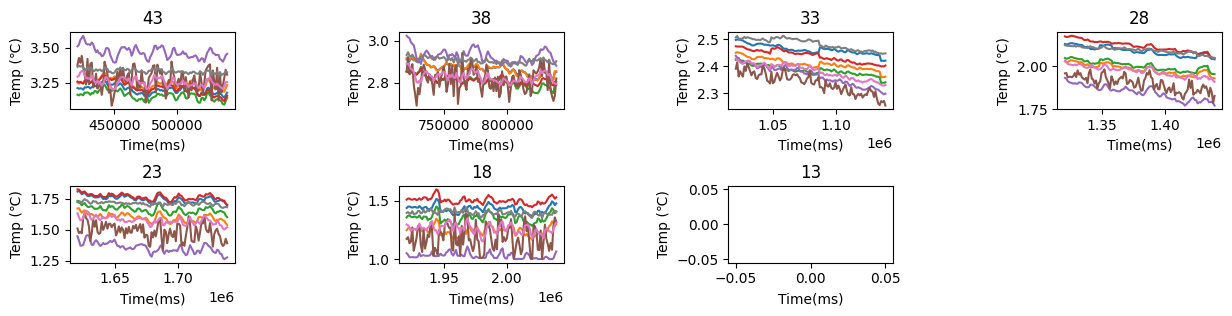

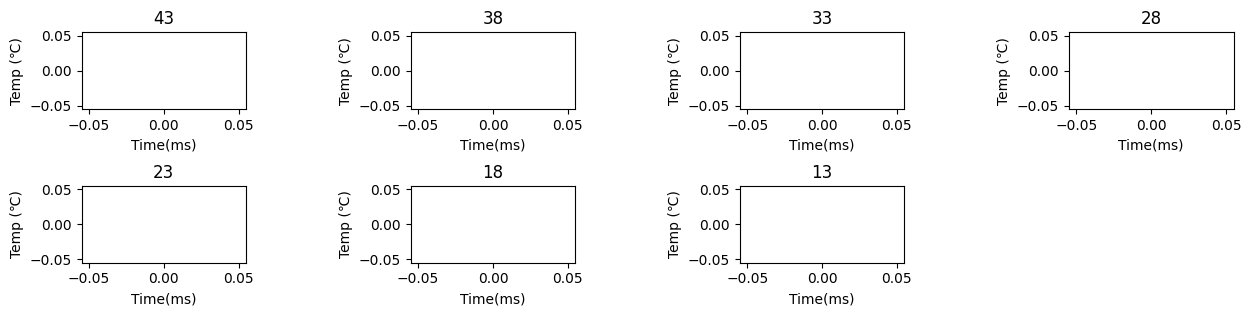

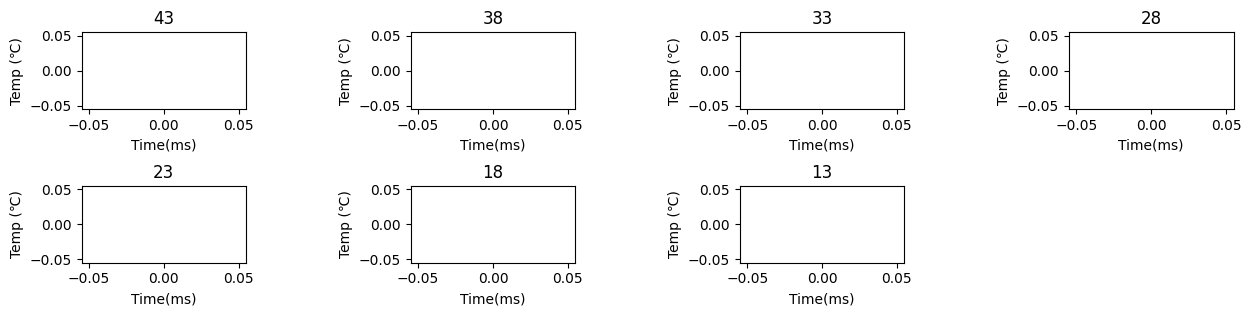

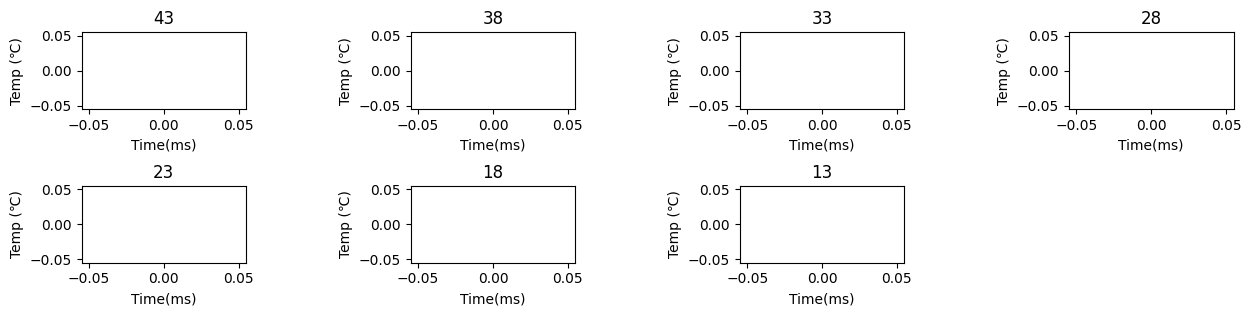

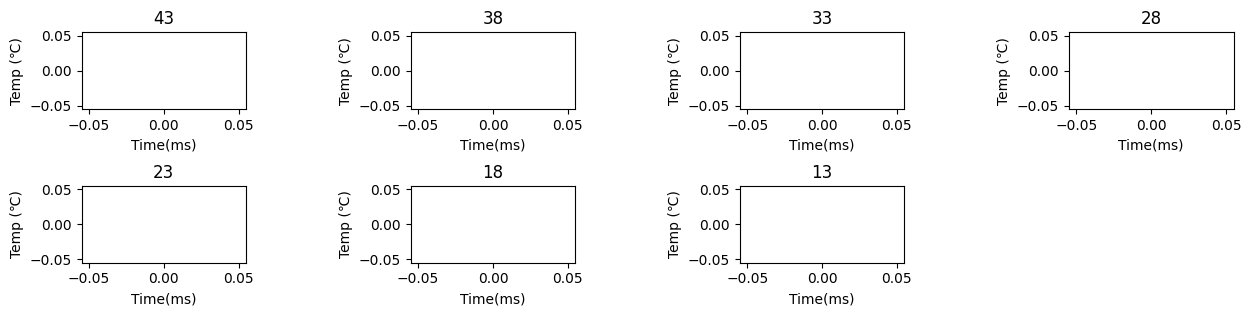

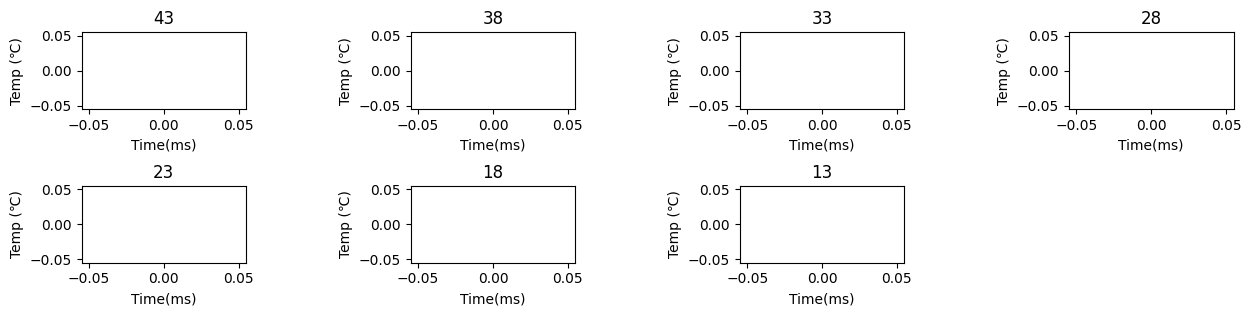

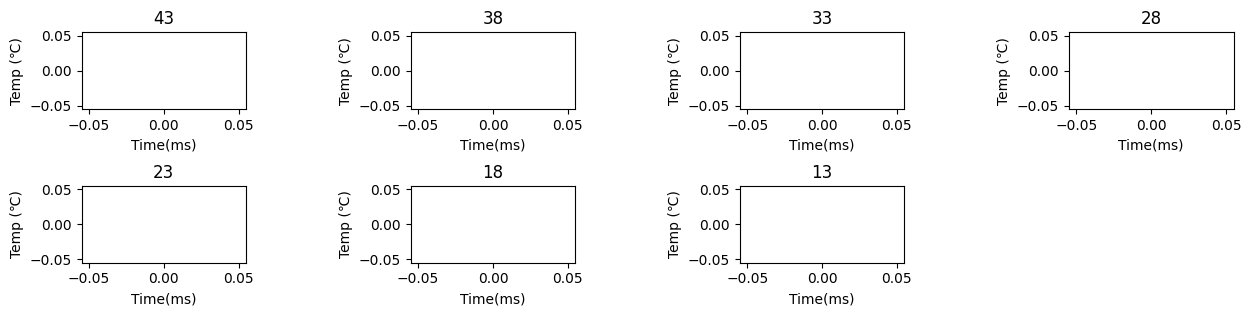

In [ ]:
conv_temp_dict = {}
conv_averaged_temp_dict = {}
conv_temp_dicts = []
avg_conv_temp_dict = {}
plt.figure()

conv_t_df = pd.DataFrame()
conv_averaged_temp_df = pd.DataFrame()
conv_ch_avg = pd.DataFrame()
conv_ch_std_dev = pd.DataFrame()

lower_bound = offset
#for each segmented temp data, convert voltage to temps and calculate mean/standard deviation
for chamber_temp in chamber_temps:
    conv_temp_dict = {}
    lower_bound += time_interval_ms #ignore first interval
    for i in range(0, temp_ranges.size):
        conv_temp_dict[str(temp_ranges[i])] = combined_data_temp[(combined_data_temp["Time(ms)"] > (lower_bound+begin_cutoff)) & (combined_data_temp["Time(ms)"] < (lower_bound + time_interval_ms-end_cutoff))]
        conv_temp_dict[str(temp_ranges[i])].insert(loc = 1,
            column = "BB Temp",
            value = temp_ranges[i])
        lower_bound += time_interval_ms

        #copy segmented temperature, perform rolling mean
        conv_temp_dict_copy = conv_temp_dict[str(temp_ranges[i])].copy()
        conv_averaged_temp_dict[str(temp_ranges[i])] = conv_temp_dict_copy[channel_col].rolling(window_size).mean()

        #re-add BB temp and time
        conv_averaged_temp_dict[str(temp_ranges[i])].insert(loc = 0,
            column = "BB Temp",
            value = temp_ranges[i])
        conv_averaged_temp_dict[str(temp_ranges[i])].insert(loc = 0,
            column = "Time(ms)",
            value = data["Time(ms)"])
        
        #drop the first few samples not in window
        conv_averaged_temp_dict[str(temp_ranges[i])].drop(conv_averaged_temp_dict[str(temp_ranges[i])].index[:window_size], inplace=True)

    conv_temp_dicts.append(conv_temp_dict)
    conv_temp_df = pd.concat(list(conv_temp_dict.values()))
    conv_temp_df.to_csv('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_temp_cleaned_' + file_name + '.csv')

    conv_averaged_temp_df = pd.concat(list(conv_averaged_temp_dict.values()))
    conv_averaged_temp_df.to_csv('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_temp_averaged_cleaned_' + file_name + '.csv')


cham_temp_index = 0 
#for each BB temp, find the average and standard deviation of the recorded temperature
for conv_temp_dict in conv_temp_dicts:
    i = 1
    conv_ch_avgs = pd.DataFrame()
    conv_ch_std_dev = pd.DataFrame()
    plt.figure()
    for temp in conv_temp_dict: 
        temp_segment = conv_temp_dict[temp]
        conv_ch_avgs[temp] = temp_segment[channel_col].mean()
        conv_ch_std_dev[temp] = temp_segment[channel_col].std()
        max_temp = temp_segment.max() #get max temps

        min_temp = temp_segment.min() #get min temps 

        conv_tpp = max_temp - min_temp
        conv_tpp_df = pd.DataFrame({'TPP' + str(temp): conv_tpp}).T
        conv_t_df = pd.concat([conv_t_df, conv_tpp_df])
        ax = plt.subplot(3, 4, i)
        plt.subplots_adjust(left=0.1, right=1.9, bottom=0.1, top=0.9, wspace=1, hspace=1)

        plt.plot(temp_segment.loc[:,"Time(ms)"], temp_segment.loc[:,channel_col])
        plt.title(temp)
        plt.ylabel("Temp (\N{DEGREE CELSIUS})")
        plt.xlabel("Time(ms)")
        i += 1

    #add converted temp averages and std deviations to the dataframe and plot them
    conv_ch_avgs=conv_ch_avgs.T
    conv_ch_avgs.insert(loc = 0, column = 'Temp', value = temp_ranges)
    conv_ch_std_dev =conv_ch_std_dev.T
    conv_ch_std_dev.insert(loc = 0, column = 'Temp', value = temp_ranges)
    #display(conv_ch_avgs)
    display(conv_ch_std_dev)
    #display(conv_t_df)
    print(conv_ch_std_dev[channel_col].loc[(conv_ch_std_dev['Temp'] <= 40) & (conv_ch_std_dev['Temp'] >= 20)].mean().mean())
    conv_ch_avgs.to_csv('Reports/' + file_name + '/' + str(chamber_temps[cham_temp_index]) + '/' + str(chamber_temps[cham_temp_index]) + '_temp_avg_' + file_name + '.csv')
    conv_ch_std_dev.to_csv('Reports/' + file_name + '/' + str(chamber_temps[cham_temp_index]) + '/' + str(chamber_temps[cham_temp_index]) + '_temp_std_dev_' + file_name + '.csv')
    cham_temp_index += 1
# -------------UNCOMMENT FOR AVERAGE MEASURED TEMPS vs BB TEMPS, REQUIRES BB TEMPS------------------#
""" for ch in channel_col:
    plt.scatter(temp_ranges, conv_ch_avgs[ch])
plt.xlabel("BB Temp. (\N{DEGREE CELSIUS})")
plt.ylabel("Average Recorded Temp. (\N{DEGREE CELSIUS})")
plt.title("Avg. Temp. vs. BB Temp")
plt.legend(channel_col, fontsize = 5)
plt.savefig('Reports/' + file_name + '/' + 'avg_temps_' + file_name + '.png', bbox_inches='tight') """
# -------------UNCOMMENT FOR AVERAGE MEASURED TEMPS vs BB TEMPS, REQUIRES BB TEMPS------------------#



# Calculating Temperature to Radiance Curves

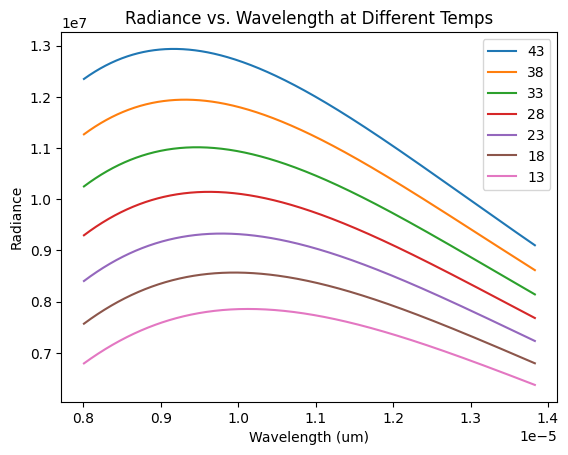

In [ ]:
#units are watt/meter squared,

#read in response curve
dex = pd.read_csv("Data/dexter_filters.csv")
dex["Wavelength"] = dex["Wavelength"] * 1e-6
#normalize each channel by dividing by the max
dex_norm = dex
for ch in channel_col:
    dex_norm[ch] = dex[ch] / dex[ch].abs().max()

#use Planck radiance equation to obtain curves
planck = pd.DataFrame()
planck["Wavelength"] = dex_norm["Wavelength"]
plt.figure()
for temp in temp_ranges:
    planck[temp] = planck_radiance((planck["Wavelength"]), temp)
    plt.plot(planck["Wavelength"], planck[temp])
    plt.legend(temp_ranges)
    plt.title("Radiance vs. Wavelength at Different Temps")
    plt.xlabel("Wavelength (um)")
    plt.ylabel("Radiance")

be_radiance = pd.DataFrame()
be_radiance["Temperature"] = temp_ranges

# calculate BE radiance at each temperature for each channel. This is technically doing an integration. 
# Since the spacing between each wavelength for the signal is the same as the calculated radiance, we can just
# do an element by element multiplication 
for ch in channel_col:
    radiance = []
    for temp in temp_ranges:
        numerator = 0
        for a, b in zip(planck[temp], dex_norm[ch]):
            numerator += a * b
        
        denominator = dex_norm[ch].sum()
        radiance.append(numerator/denominator)
    be_radiance[ch] = radiance

#display(be_radiance)



# Plot radiance vs. time from data

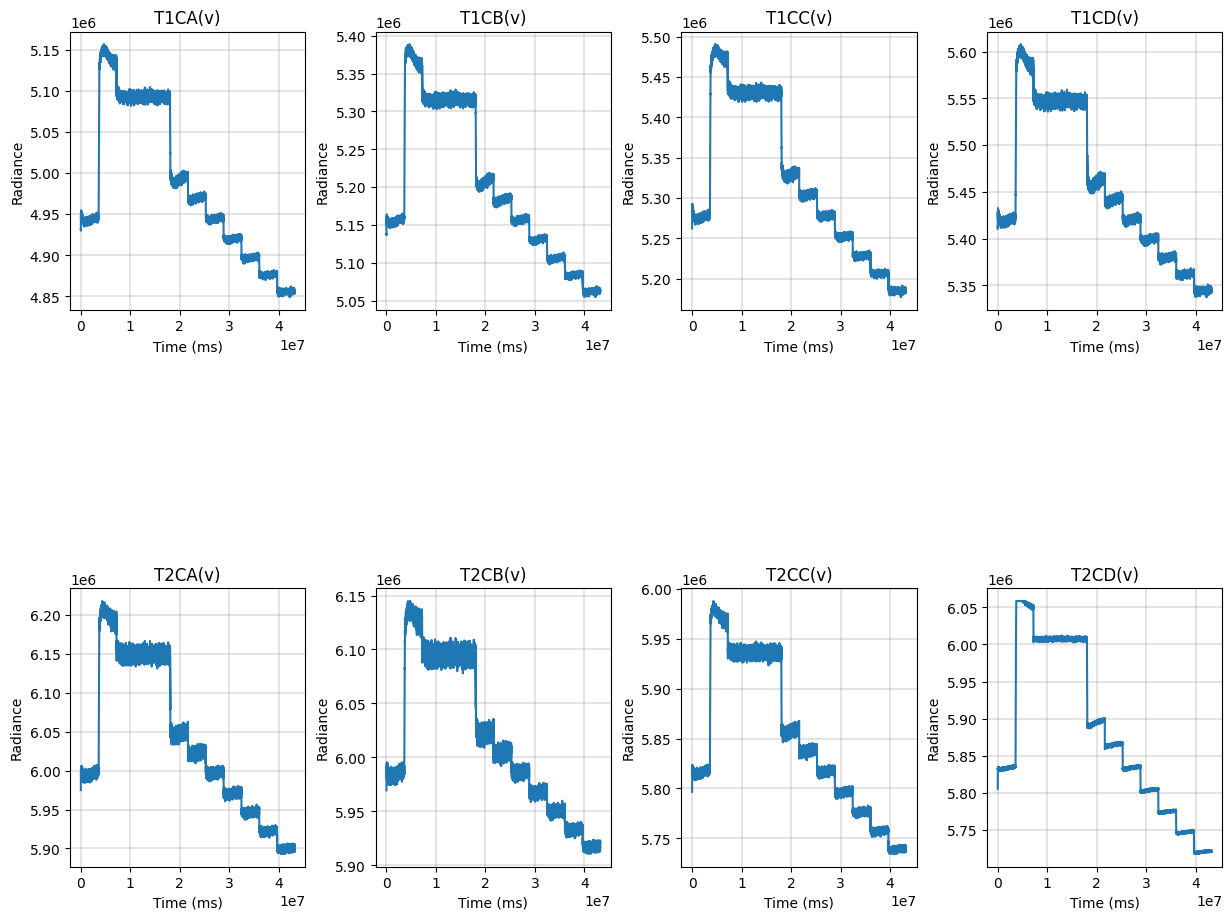

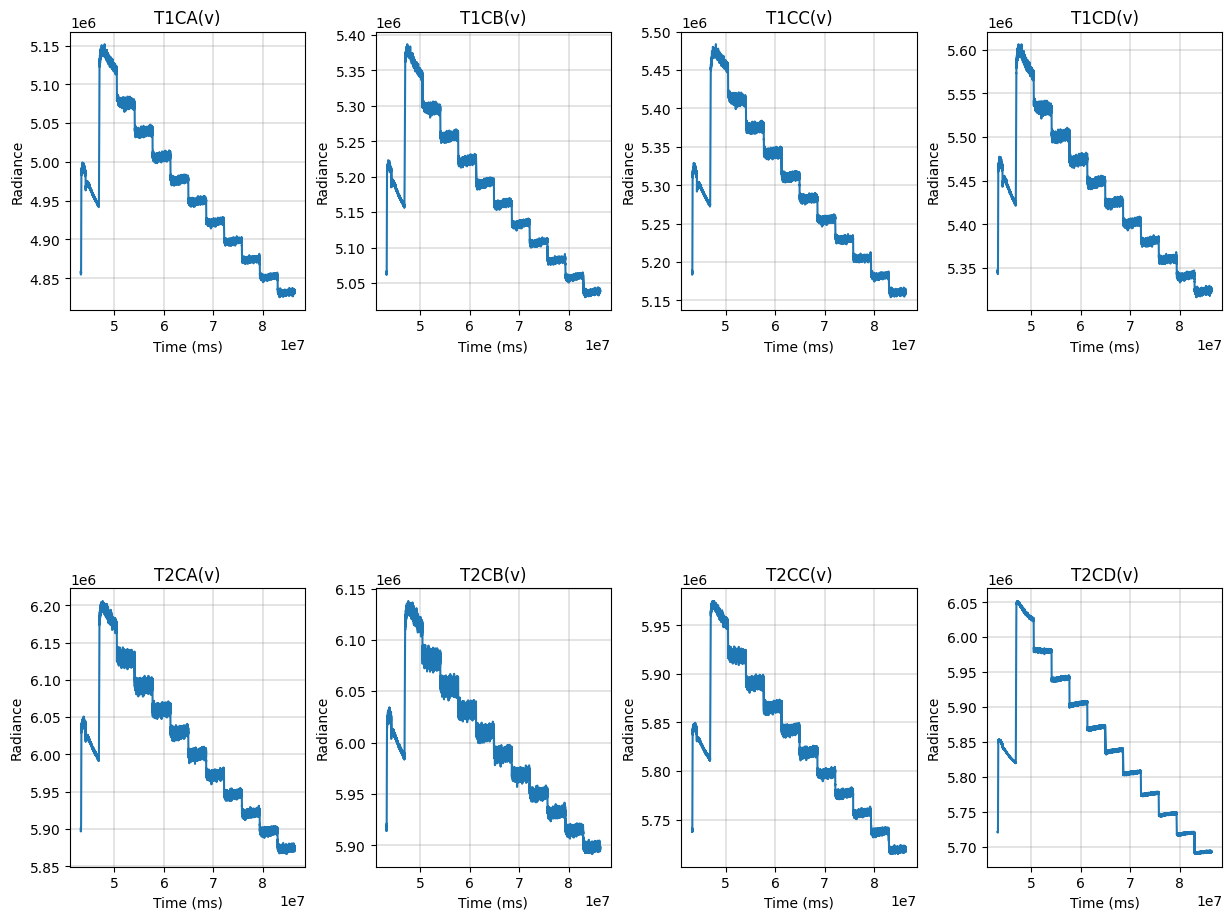

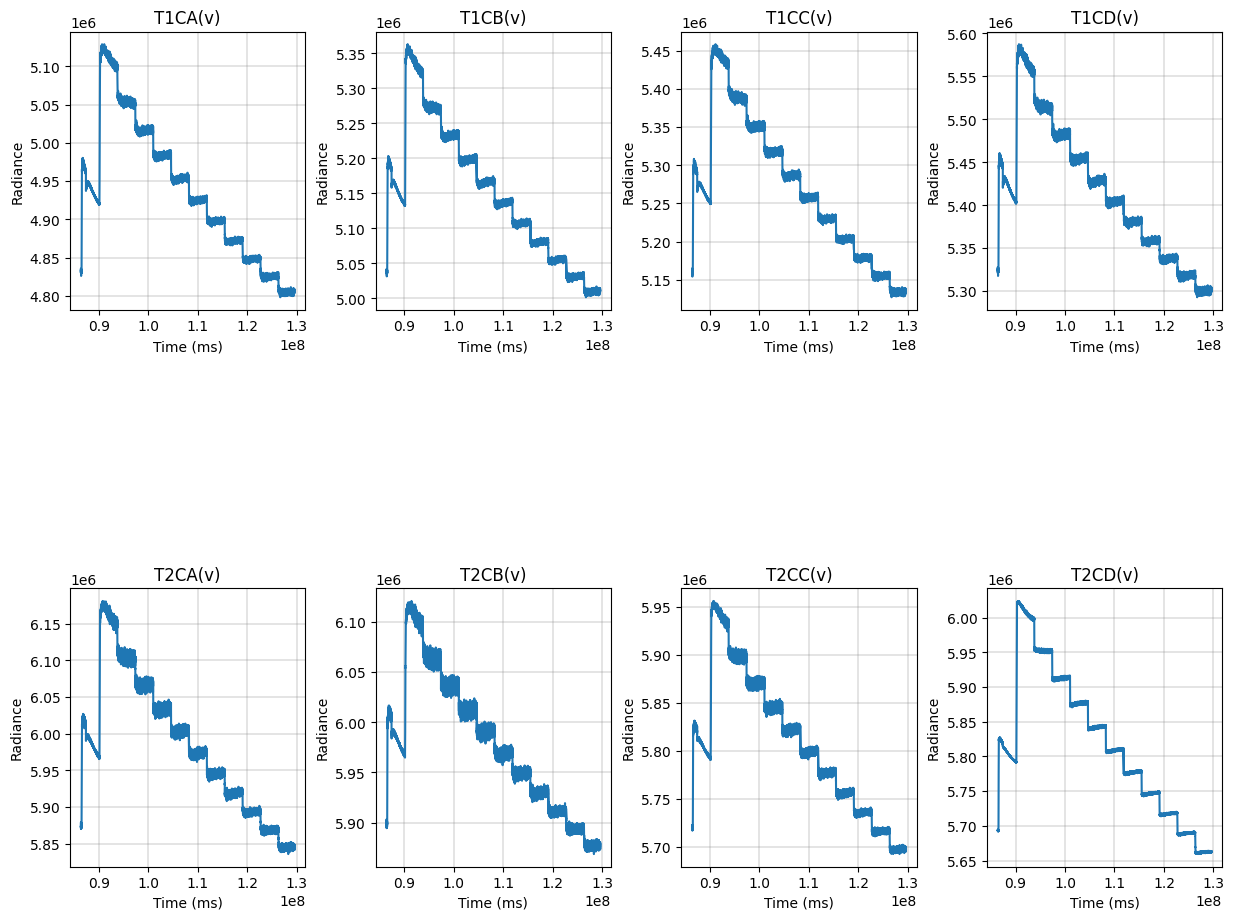

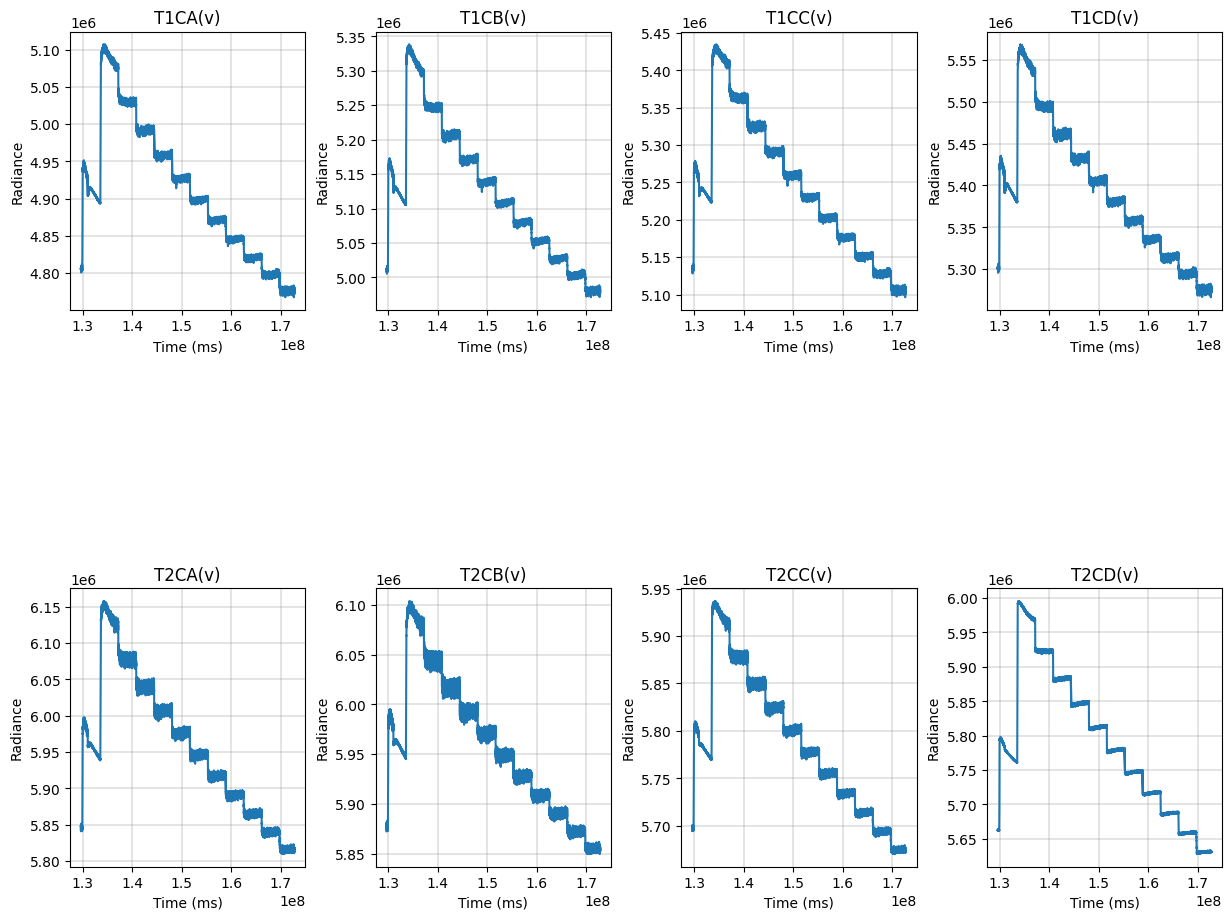

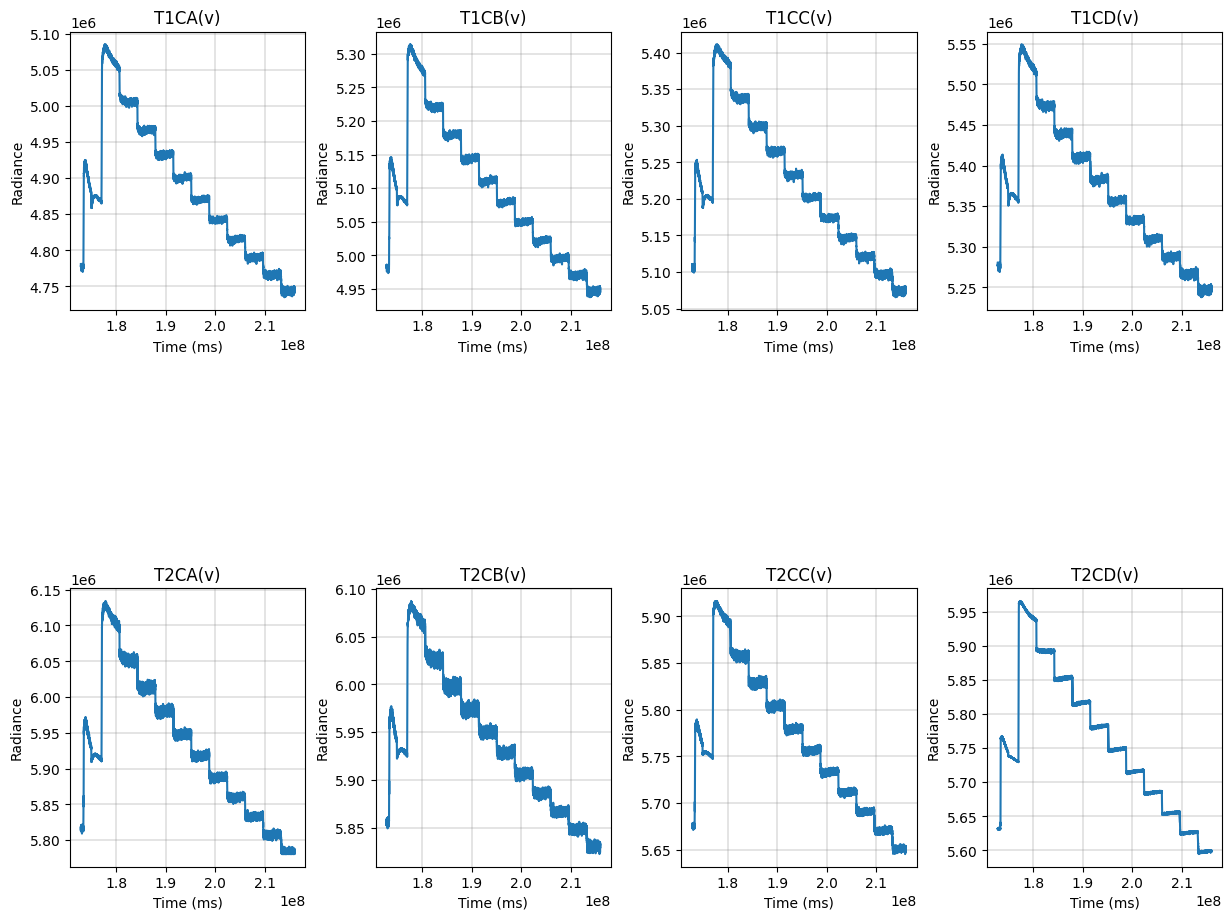

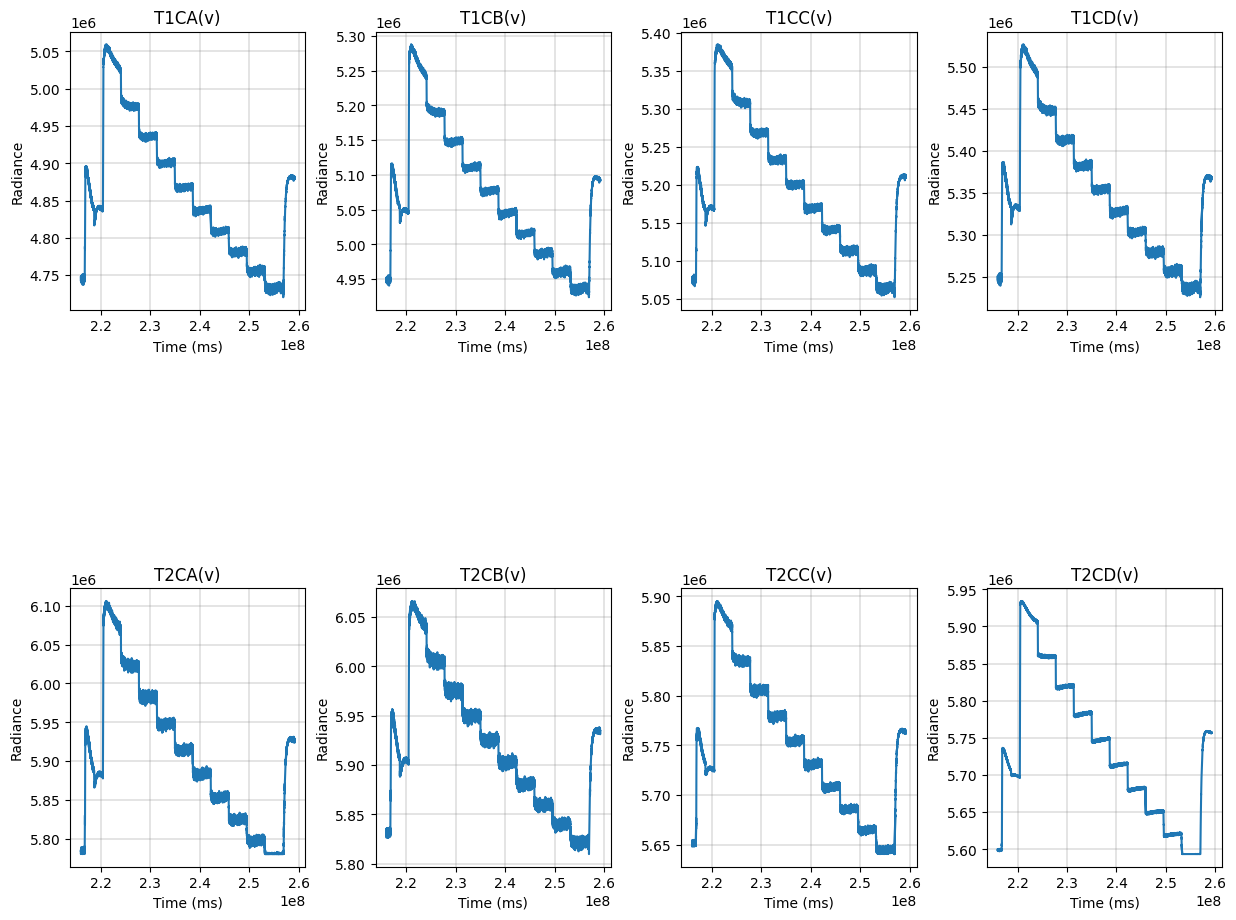

In [ ]:
combined_data_rad = pd.DataFrame()

#parameters for linear fit for each channel
rad_popt = {}
rad_pcov = {}

#used to indicate which chamber temp is currently being run
cham_temp_index = 0
for temp_data_to_convert in data_chamber_temps:
    data_rad = temp_data_to_convert.copy()

    plt.figure()
    i = 1
    for chan in channel_col:
        #apply linear fit for each channel
        rad_popt[chan], rad_pcov[chan] = curve_fit(linear_fit, be_radiance["Temperature"], be_radiance[chan])
        calc_rad = linear_fit(data_rad[chan], *rad_popt[chan])
        data_rad[chan] = calc_rad
        ax = plt.subplot(3, 4, i)
        plt.subplots_adjust(left=0.1, right=1.9, bottom=0.1, top=3, wspace=0.3, hspace=1)
        
        #plot radiance vs. time
        plt.plot(data_rad.loc[:,"Time(ms)"], data_rad[chan])
        plt.xlabel("Time (ms)")
        plt.ylabel("Radiance")
        plt.title(chan)
        plt.grid(color='gray', linestyle='-', linewidth=0.3)
        i += 1
    plt.savefig('Reports/' + file_name + '/' + str(chamber_temps[cham_temp_index]) + '/' + str(chamber_temps[cham_temp_index]) + '_indiv_channel_temps_' + file_name + '.png', bbox_inches='tight')    
    
    #add converted data to combined dataframe and increase index  by 1
    cham_temp_index += 1 
    combined_data_rad = pd.concat([combined_data_rad, data_rad])

#save radiance data to csv
combined_data_rad.to_csv('Reports/' + file_name + '/' + 'converted_rads_' + file_name + '.csv')
plt.show()

In [ ]:
#calculate radiance in temperature domain (THIS PART IS WIP)
rad_dict = {}
plt.figure()

rad_ch_avgs = pd.DataFrame()
rad_ch_std_dev = pd.DataFrame()
lower_bound = offset
#for each segmented temp data, convert voltage to temps and calculate mean/standard deviation
for i in range(0, temp_ranges.size):
    rad_dict[str(temp_ranges[i])] = data_radiance[(data_radiance["Time(ms)"] > (lower_bound+begin_cutoff)) & (data_radiance["Time(ms)"] < (lower_bound + time_interval_ms-end_cutoff))]
    lower_bound += time_interval_ms

#for each BB temp, find the average and standard deviation of the recorded temperature
for rad in rad_dict:
    rad_segment = rad_dict[rad]
    rad_ch_avgs[rad] = rad_segment[channel_col].mean()
    rad_ch_std_dev[rad] = rad_segment[channel_col].std()

#calculate averages/standard deviations for radiance
rad_ch_avgs=rad_ch_avgs.T
rad_ch_avgs.insert(loc = 0, column = 'Temp', value = temp_ranges)
rad_ch_std_dev =rad_ch_std_dev.T
rad_ch_std_dev.insert(loc = 0, column = 'Temp', value = temp_ranges)
display(rad_ch_avgs)
display(rad_ch_std_dev)
for ch in channel_col:
    plt.scatter(temp_ranges, rad_ch_avgs[ch])
plt.xlabel("BB Temp. (\N{DEGREE CELSIUS})")
plt.ylabel("Average Recorded Radiance (\N{DEGREE CELSIUS})")
plt.title("Avg. Radiance vs. BB Temp")
plt.legend(channel_col, fontsize = 5)

NameError: name 'data_radiance' is not defined

<Figure size 640x480 with 0 Axes>